In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torchbnn as bnn 
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.metrics import (accuracy_score, precision_score, confusion_matrix,
                             roc_auc_score, brier_score_loss, roc_curve,
                             mean_squared_error, mean_absolute_error, r2_score,  classification_report,
                             )


from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier 
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import time

**Traditional neural networks** learn fixed numbers to make predictions, even if the training data is small or messy.<br>
**BNNs** use ranges of possible values (probability distributions) for weights, BNNs sample multiple guesses from those ranges. <br>If the guesses are similar, the model is confident; if they vary wildly, it admits uncertainty.

In [2]:
# I am using the diabetes dataset from Introduction ML Course 
df = pd.read_csv('diabetes_cleaned.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.00,79.8,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.00,79.8,26.6,0.351,31.0,0
2,8.0,183.0,64.0,20.54,79.8,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.00,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.00,168.0,43.1,1.200,33.0,1


**Preprocessing**

In [3]:
df.shape

(768, 9)

In [4]:
# Features and target value
# Since I will train BBN model in Pytorch framework, I need numpy array with no label
X = df.drop(columns=['Outcome']).values 
y = df['Outcome'].values 

# Standardize the features
scaler = StandardScaler()
#X = scaler.fit_transform(X)

# Making train/ validation and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)


# Convert NumPy arrays into PyTorch tensors
X_train, X_val, X_test = [torch.tensor(a, dtype=torch.float32) for a in (X_train, X_val, X_test)]
y_train, y_val, y_test = [torch.tensor(a, dtype=torch.long)   for a in (y_train, y_val, y_test)]

print(f'X train shape:{X_train.shape} y train shape:{y_train.shape}')
print(f'\nX validation shape:{X_val.shape} validation shape:{y_val.shape}')
print(f'\nX test shape:{X_test.shape} y test shape:{y_test.shape}')

X train shape:torch.Size([614, 8]) y train shape:torch.Size([614])

X validation shape:torch.Size([77, 8]) validation shape:torch.Size([77])

X test shape:torch.Size([77, 8]) y test shape:torch.Size([77])


Establish a baseline with XGBoost classifier

In [5]:
# Baseline test with XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, 
                    n_estimators=500,
                    max_depth=7,
                    learning_rate=0.01,
                    eval_metric='logloss')
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)


[0]	validation_0-logloss:0.64417
[1]	validation_0-logloss:0.64060
[2]	validation_0-logloss:0.63705
[3]	validation_0-logloss:0.63360
[4]	validation_0-logloss:0.63032
[5]	validation_0-logloss:0.62710
[6]	validation_0-logloss:0.62384
[7]	validation_0-logloss:0.62051
[8]	validation_0-logloss:0.61720
[9]	validation_0-logloss:0.61425
[10]	validation_0-logloss:0.61129
[11]	validation_0-logloss:0.60823
[12]	validation_0-logloss:0.60545
[13]	validation_0-logloss:0.60269
[14]	validation_0-logloss:0.59996
[15]	validation_0-logloss:0.59703
[16]	validation_0-logloss:0.59447
[17]	validation_0-logloss:0.59145
[18]	validation_0-logloss:0.58848
[19]	validation_0-logloss:0.58587
[20]	validation_0-logloss:0.58334
[21]	validation_0-logloss:0.58055
[22]	validation_0-logloss:0.57784
[23]	validation_0-logloss:0.57511
[24]	validation_0-logloss:0.57261
[25]	validation_0-logloss:0.57015
[26]	validation_0-logloss:0.56762
[27]	validation_0-logloss:0.56524
[28]	validation_0-logloss:0.56286
[29]	validation_0-loglos

c:\Work\reinforcement-learning\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:48:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[75]	validation_0-logloss:0.48833
[76]	validation_0-logloss:0.48708
[77]	validation_0-logloss:0.48607
[78]	validation_0-logloss:0.48507
[79]	validation_0-logloss:0.48416
[80]	validation_0-logloss:0.48280
[81]	validation_0-logloss:0.48154
[82]	validation_0-logloss:0.48051
[83]	validation_0-logloss:0.47968
[84]	validation_0-logloss:0.47837
[85]	validation_0-logloss:0.47721
[86]	validation_0-logloss:0.47638
[87]	validation_0-logloss:0.47563
[88]	validation_0-logloss:0.47444
[89]	validation_0-logloss:0.47352
[90]	validation_0-logloss:0.47234
[91]	validation_0-logloss:0.47164
[92]	validation_0-logloss:0.47074
[93]	validation_0-logloss:0.46956
[94]	validation_0-logloss:0.46893
[95]	validation_0-logloss:0.46773
[96]	validation_0-logloss:0.46753
[97]	validation_0-logloss:0.46673
[98]	validation_0-logloss:0.46581
[99]	validation_0-logloss:0.46560
[100]	validation_0-logloss:0.46544
[101]	validation_0-logloss:0.46449
[102]	validation_0-logloss:0.46338
[103]	validation_0-logloss:0.46276
[104]	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [6]:
# Test the model on the validation set
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"XGBoost Validation Accuracy: {accuracy:.4f}")
print(f"XGBoost Validation Precision: {precision:.4f}")
print(f"XGBoost Validation ROC AUC: {roc_auc:.4f}")
print(f"XGBoost Validation Confusion Matrix:\n{confusion}")

XGBoost Validation Accuracy: 0.7143
XGBoost Validation Precision: 0.5862
XGBoost Validation ROC AUC: 0.7689
XGBoost Validation Confusion Matrix:
[[38 12]
 [10 17]]


In [7]:
# Classification report
print(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes']))

              precision    recall  f1-score   support

 No Diabetes       0.79      0.76      0.78        50
    Diabetes       0.59      0.63      0.61        27

    accuracy                           0.71        77
   macro avg       0.69      0.69      0.69        77
weighted avg       0.72      0.71      0.72        77



With that baseline we know an approximate score we should aim for.

In [8]:
# Bundle tensors into mini batch loaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)
print(f'Train loader: {len(train_loader)} batches')
print(f'Validation loader: {len(val_loader)} batches')
print(f'Test loader: {len(test_loader)} batches')

Train loader: 20 batches
Validation loader: 3 batches
Test loader: 3 batches


In [9]:
# Distribution Mean:
# Adjust the mean of the distribution to be 0, the model learns nearly to 0 (Symmetric), it is good to avoid model from bias.

# Noise Standard Deviation:
# This parameter is used to control the amount of randomness in the model. 

# LK regularization:
# This parameter is used to measures difference between the learning weight and the prior distribution
# This regularization controls divergence to balance simplicity and data fit. 

# Monte Carlo Samples:
# This controls the number of samples used to estimate the uncertainty. Sample is number of forward passes through the model.
# Source:
# https://krasserm.github.io/2019/03/14/bayesian-neural-networks/?

**Building the Bayesian Neural Network Model**

In [10]:
# I define the Bayesian neural network architecture 
class ClassificationBNN(nn.Module):
    def __init__(self, input_dim, output_dim, mu = 0, sigma = 0.5):
        super(ClassificationBNN, self).__init__()
        self.fc1 = bnn.BayesLinear(prior_mu=mu, prior_sigma = sigma, in_features=input_dim, out_features=128)
        self.fc2 = bnn.BayesLinear(prior_mu=mu, prior_sigma = sigma, in_features=128, out_features=64)
        self.fc3 = bnn.BayesLinear(prior_mu=mu, prior_sigma = sigma, in_features =64, out_features = 64)
        self.fc4 = bnn.BayesLinear(prior_mu=mu, prior_sigma = sigma, in_features =64, out_features = 64)
        self.out = bnn.BayesLinear(prior_mu=mu, prior_sigma = sigma, in_features =64, out_features = output_dim)
        self.relu = nn.ReLU()     
        self.sigmoid = nn.Sigmoid()
        
# I used in each layer mean and standard deviation to define the prior distribution over the weights
# Here mean and standard deviation balance the data fitting and regularization.
  
        # BatchNorm normalizes the input to each layer by subtracting the batch mean and dividing by the batch standard deviation.
        # This stabilizes training
        self.bn1, self.bn2, self.bn3, self.bn4 = nn.BatchNorm1d(128), nn.BatchNorm1d(64), nn.BatchNorm1d(64), nn.BatchNorm1d(64)  
        self.dropout = nn.Dropout(0.5)  
        
# I applied layers with probabilistic weights instead  of fixed values to the input 
# Then I applied Relu to accelerates the convergence and helps the model to learn complex patterns
# For stabilizing, I applied batch normalization to the output Relu
# Dropout will be activated when only  mac_dropout is set to True
    def forward(self, x, mc_dropout=False):
        x = self.dropout(self.bn1(self.relu(self.fc1(x)))) if mc_dropout else self.bn1(self.relu(self.fc1(x)))
        x = self.dropout(self.bn2(self.relu(self.fc2(x)))) if mc_dropout else self.bn2(self.relu(self.fc2(x)))
        x = self.dropout(self.bn3(self.relu(self.fc3(x)))) if mc_dropout else self.bn3(self.relu(self.fc3(x)))
        x = self.dropout(self.bn4(self.relu(self.fc4(x)))) if mc_dropout else self.bn4(self.relu(self.fc4(x)))
        x = self.sigmoid(self.out(x))
        return x
    
    
# I have 8 features and 1 output 
# I defined 3 hidden layers with 128, 64, 32 neurons and 16 to extract the features from the input data
# The Final layer has 1 output neuron since my dataset is binary classification
# I defined dropout and batch normalization layers for regularization

# In this structure:
# bnn.BayesLinear layers replace nn.Linear that maintain distributions over weights and biases instead of single values
# The forward method defines how input data flows through the network.
# I initialized prior_ mu to 0 because what I have learned, it is a common  practice to keep weights neutral 
# at the beginning of training.
# I initialized prior_sigma to 0.5 that weights to as adapt more freely during training.

**Initializing model anf Hyperparameter**

In [11]:
# Hyperparameters:
lambda_kl = 0.05 
mc_samples_eval = 100
learning_rate = 0.005
weight_decay = 0.0001

# I initialize lambda_kl to 0.1, which is not too high to force the wights to be close to the prior distribution
# 50 samples for Monte Carlo  is a good number to learn distribution of weights after training.
# 100 samples is a good number to estimate the uncertainty 
# learning rate is 0.0009 is safe for adam optimizer to learn stable without overshooting
# weight decay is 0.0005 to prevent overfitting and improve generalization of the model
criterion = nn.BCELoss() # Binary Cross Entropy Loss for binary classification
kl_loss = bnn.BKLLoss(reduction = 'mean')
# I use BKLLoss to calculate the Kullback-Leibler divergence between the learned distribution and the prior distribution 
model  = ClassificationBNN(input_dim=8, output_dim=1, mu=0, sigma=0.5)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

**Training Loop**

In [ ]:
@torch.no_grad()                                     
def evaluate(model, loader, mc_samples=mc_samples_eval, threshold=0.5):
    model.eval()                                  
    all_probs, all_true, uncertainties = [], [], []
    for input_feature, true_label in loader: 
        # Monte Carlo sampling for uncertainty estimation  
        # By running the model multiple times with dropout, I can capture the uncertainty in the predictions  
        # Adding  new dimension to aggregate Monte Carlo samples 
        # Each time returns tensor of shape (batch_size, 1) logits for binary classification         
        mc_probs = torch.stack([model(input_feature ) for _ in range(mc_samples)])  
        probs = mc_probs.mean(dim=0).squeeze()
        uncertainties.append(mc_probs.std(dim=0).squeeze())  # Store uncertainties for each sample
        # Collecting probabilities and true labels for evaluation
        all_probs.append(probs)
        all_true.append(true_label)
    # Compute metrics
    probs = torch.cat(all_probs)                      
    y_true = torch.cat(all_true).float()
    # Convert probabilities to class labels using the threshold
    y_pred = (probs > threshold).float()             
    # Calculate accuracy by comparing predicted labels with true labels  
    accuracy = (y_pred == y_true).float().mean().item()      
    return accuracy, probs, y_true, uncertainties
# What I learned:
# Monte Carlo is a clever way to guess how sure my model is about diabetes prediction
# During training, dropout randomly neurons, To preventing overfitting by making the BNN robust to missing parts                
# Each time I run the model, it gives me a different answer, because different neurons are dropped each time
# Sources:
# https://medium.com/biased-algorithms/uncertainty-estimation-in-machine-learning-with-monte-carlo-dropout-72377f5ee276

In [13]:
# Training the model 
def train(model, loader, optimizer, Lambda_kl=lambda_kl):
    # training mode
    model.train()
    running = 0

    for input_feature, true_label in loader:
        # Zero Gradients 
        optimizer.zero_grad()
        # Forward pass: compute  raw output from input features
        logits = model(input_feature, mc_dropout=True)  # Enable dropout during training
        # Compute the loss        
        loss_data = criterion(logits.squeeze(1), true_label.float())
        # Compute the KL divergence loss:
        # Iterates over all layers amd filters layers that have a kl_loss() method 
        # And st the end, computes the KL divergence for each Bayesian layer between its posterior and prior distributions.
        kl = kl_loss(model)
        loss = loss_data + Lambda_kl * kl
        loss.backward()
        optimizer.step()
        running += loss.item() * input_feature.size(0)
    return running / len(loader.dataset)
# I did not use float32 for the labels  and I got an error:
# RuntimeError: result type Float can't be cast to the desired output type Long
# I used Qwen to ask why I got this error and it suggested to float the labels for compatibility with
# the BCEWithLogitsLoss 

# What I learned from adjusting the kl to different values:
# In BNN KL has L2 regularization
# If KL value is too high, the model can not learn anything from the data.
# If KL value is too low, the model can learn from the data but the model is overfitting

In [14]:
# History and hyperparameters
history = {'train_loss': [], 'val_acc': [], 'val_nll': []}
best_val_acc = 0
best_val_nll = float('inf')
PATIENCE = 500
# I created empty list to hold  the validation negative log likelihood (val_nll) and accuracy for each epoch
# Validation negative log likelihood is used to evaluate how well a probabilistic model  predicts the true labels on a validation dataset.

In [15]:
from IPython.display import clear_output

In [16]:
# Training loop 
print('Training the model...')
start_time = time.time()

# Get initial model state for early stopping
best_state = model.state_dict()

for epoch in tqdm(range(5000), desc='Epoch Progress'):
    # Compute validation negative log likelihood using the BCEWithLogitsLoss 
    # to measure predictive uncertainty
    train_loss = train(model, train_loader, optimizer, lambda_kl)
    val_acc, val_probs, val_true, uncertainties = evaluate(model, val_loader, mc_samples=50)
    val_nll = criterion(val_probs, val_true).item() 
    
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_nll'].append(val_nll)
    
    
    print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val loss: {val_nll:.4f}, best val acc: {best_val_acc:.4f}')
    
    # Check for val accuracy improvement
    if val_acc > best_val_acc or val_nll < best_val_nll:
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        if val_nll < best_val_nll:
            best_val_nll = val_nll
        patience_counter = 0
        # Save the best model state
        best_state = model.state_dict()
        print(f'Best model state saved at epoch {epoch + 1}')
        clear_output(wait=True)
    else:
        patience_counter += 1
    
    

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f'\nEarly stopping at Epoch {epoch} | Best Val Acc: {best_val_acc:.4f}')
        print("Loading best model state...")
        # Load the best model state
        model.load_state_dict(best_state)
        break


print(f'Training finished! Total duration: {time.time() - start_time:.2f}s')



# I got the early stopping code from Qwen
# I got the main code structures for this assignment from the lecture note
# In some parts I used Qwen to understand the lines of code.
# But I am not confident if I understand all the concept of BNN, I need to practice more to understand the concept of BNN
# In this assignment I tried to code what I learned from the lecture notes.

Epoch Progress:  19%|█▊        | 934/5000 [04:17<17:57,  3.77it/s]

Epoch 934: Train Loss: 0.4961, Val Accuracy: 0.7143, Val loss: 0.4669, best val acc: 0.7792


Epoch Progress:  19%|█▊        | 935/5000 [04:17<17:33,  3.86it/s]

Epoch 935: Train Loss: 0.4882, Val Accuracy: 0.7143, Val loss: 0.4724, best val acc: 0.7792


Epoch Progress:  19%|█▊        | 936/5000 [04:17<17:48,  3.80it/s]

Epoch 936: Train Loss: 0.4941, Val Accuracy: 0.7143, Val loss: 0.4778, best val acc: 0.7792


Epoch Progress:  19%|█▊        | 937/5000 [04:17<18:16,  3.71it/s]

Epoch 937: Train Loss: 0.4947, Val Accuracy: 0.7143, Val loss: 0.4707, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 938/5000 [04:18<18:10,  3.72it/s]

Epoch 938: Train Loss: 0.4986, Val Accuracy: 0.7143, Val loss: 0.4753, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 939/5000 [04:18<18:40,  3.62it/s]

Epoch 939: Train Loss: 0.4946, Val Accuracy: 0.7143, Val loss: 0.4865, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 940/5000 [04:18<18:20,  3.69it/s]

Epoch 940: Train Loss: 0.4783, Val Accuracy: 0.7273, Val loss: 0.4756, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 941/5000 [04:18<18:05,  3.74it/s]

Epoch 941: Train Loss: 0.5033, Val Accuracy: 0.7143, Val loss: 0.4771, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 942/5000 [04:19<18:15,  3.70it/s]

Epoch 942: Train Loss: 0.5163, Val Accuracy: 0.7662, Val loss: 0.4757, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 943/5000 [04:19<18:07,  3.73it/s]

Epoch 943: Train Loss: 0.5009, Val Accuracy: 0.7143, Val loss: 0.4737, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 944/5000 [04:19<18:38,  3.63it/s]

Epoch 944: Train Loss: 0.5055, Val Accuracy: 0.7143, Val loss: 0.4764, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 945/5000 [04:20<18:29,  3.66it/s]

Epoch 945: Train Loss: 0.5020, Val Accuracy: 0.7143, Val loss: 0.4772, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 946/5000 [04:20<18:40,  3.62it/s]

Epoch 946: Train Loss: 0.4917, Val Accuracy: 0.7143, Val loss: 0.4787, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 947/5000 [04:20<18:28,  3.66it/s]

Epoch 947: Train Loss: 0.5096, Val Accuracy: 0.7143, Val loss: 0.4800, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 948/5000 [04:20<18:28,  3.66it/s]

Epoch 948: Train Loss: 0.4806, Val Accuracy: 0.7143, Val loss: 0.4779, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 949/5000 [04:21<19:30,  3.46it/s]

Epoch 949: Train Loss: 0.4845, Val Accuracy: 0.7143, Val loss: 0.4691, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 950/5000 [04:21<20:00,  3.37it/s]

Epoch 950: Train Loss: 0.4961, Val Accuracy: 0.7403, Val loss: 0.4756, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 951/5000 [04:21<19:57,  3.38it/s]

Epoch 951: Train Loss: 0.5244, Val Accuracy: 0.7532, Val loss: 0.4745, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 952/5000 [04:22<20:03,  3.36it/s]

Epoch 952: Train Loss: 0.4680, Val Accuracy: 0.7143, Val loss: 0.4702, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 953/5000 [04:22<20:04,  3.36it/s]

Epoch 953: Train Loss: 0.5216, Val Accuracy: 0.7143, Val loss: 0.4728, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 954/5000 [04:22<21:02,  3.21it/s]

Epoch 954: Train Loss: 0.4956, Val Accuracy: 0.7143, Val loss: 0.4753, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 955/5000 [04:23<20:49,  3.24it/s]

Epoch 955: Train Loss: 0.4937, Val Accuracy: 0.7273, Val loss: 0.4755, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 956/5000 [04:23<20:13,  3.33it/s]

Epoch 956: Train Loss: 0.5066, Val Accuracy: 0.7143, Val loss: 0.4763, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 957/5000 [04:23<20:00,  3.37it/s]

Epoch 957: Train Loss: 0.5153, Val Accuracy: 0.7143, Val loss: 0.4714, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 958/5000 [04:23<19:46,  3.41it/s]

Epoch 958: Train Loss: 0.4961, Val Accuracy: 0.7143, Val loss: 0.4792, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 959/5000 [04:24<20:28,  3.29it/s]

Epoch 959: Train Loss: 0.4834, Val Accuracy: 0.7143, Val loss: 0.4796, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 960/5000 [04:24<20:00,  3.36it/s]

Epoch 960: Train Loss: 0.5161, Val Accuracy: 0.7013, Val loss: 0.4746, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 961/5000 [04:24<19:34,  3.44it/s]

Epoch 961: Train Loss: 0.5094, Val Accuracy: 0.7273, Val loss: 0.4728, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 962/5000 [04:25<19:17,  3.49it/s]

Epoch 962: Train Loss: 0.5113, Val Accuracy: 0.7273, Val loss: 0.4810, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 963/5000 [04:25<18:48,  3.58it/s]

Epoch 963: Train Loss: 0.5114, Val Accuracy: 0.7143, Val loss: 0.4866, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 964/5000 [04:25<19:04,  3.52it/s]

Epoch 964: Train Loss: 0.4916, Val Accuracy: 0.7403, Val loss: 0.4825, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 965/5000 [04:25<18:53,  3.56it/s]

Epoch 965: Train Loss: 0.4976, Val Accuracy: 0.7273, Val loss: 0.4844, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 966/5000 [04:26<18:31,  3.63it/s]

Epoch 966: Train Loss: 0.4956, Val Accuracy: 0.7403, Val loss: 0.4855, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 967/5000 [04:26<18:35,  3.61it/s]

Epoch 967: Train Loss: 0.4983, Val Accuracy: 0.7143, Val loss: 0.4807, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 968/5000 [04:26<18:40,  3.60it/s]

Epoch 968: Train Loss: 0.5034, Val Accuracy: 0.7143, Val loss: 0.4766, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 969/5000 [04:27<19:02,  3.53it/s]

Epoch 969: Train Loss: 0.4801, Val Accuracy: 0.7143, Val loss: 0.4785, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 970/5000 [04:27<18:37,  3.61it/s]

Epoch 970: Train Loss: 0.4943, Val Accuracy: 0.7143, Val loss: 0.4765, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 971/5000 [04:27<18:30,  3.63it/s]

Epoch 971: Train Loss: 0.5058, Val Accuracy: 0.7143, Val loss: 0.4770, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 972/5000 [04:27<17:59,  3.73it/s]

Epoch 972: Train Loss: 0.4933, Val Accuracy: 0.7143, Val loss: 0.4712, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 973/5000 [04:28<17:36,  3.81it/s]

Epoch 973: Train Loss: 0.4966, Val Accuracy: 0.7273, Val loss: 0.4711, best val acc: 0.7792


Epoch Progress:  19%|█▉        | 974/5000 [04:28<18:11,  3.69it/s]

Epoch 974: Train Loss: 0.4767, Val Accuracy: 0.7143, Val loss: 0.4786, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 975/5000 [04:28<17:47,  3.77it/s]

Epoch 975: Train Loss: 0.4974, Val Accuracy: 0.7143, Val loss: 0.4792, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 976/5000 [04:28<17:46,  3.77it/s]

Epoch 976: Train Loss: 0.4999, Val Accuracy: 0.7403, Val loss: 0.4753, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 977/5000 [04:29<18:03,  3.71it/s]

Epoch 977: Train Loss: 0.4940, Val Accuracy: 0.7403, Val loss: 0.4707, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 978/5000 [04:29<17:52,  3.75it/s]

Epoch 978: Train Loss: 0.5088, Val Accuracy: 0.7273, Val loss: 0.4704, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 979/5000 [04:29<18:31,  3.62it/s]

Epoch 979: Train Loss: 0.5109, Val Accuracy: 0.7403, Val loss: 0.4698, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 980/5000 [04:30<18:13,  3.68it/s]

Epoch 980: Train Loss: 0.4885, Val Accuracy: 0.7403, Val loss: 0.4717, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 981/5000 [04:30<18:06,  3.70it/s]

Epoch 981: Train Loss: 0.4939, Val Accuracy: 0.7143, Val loss: 0.4748, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 982/5000 [04:30<17:55,  3.73it/s]

Epoch 982: Train Loss: 0.5003, Val Accuracy: 0.7662, Val loss: 0.4785, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 983/5000 [04:30<17:55,  3.73it/s]

Epoch 983: Train Loss: 0.4907, Val Accuracy: 0.7143, Val loss: 0.4774, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 984/5000 [04:31<18:15,  3.66it/s]

Epoch 984: Train Loss: 0.4870, Val Accuracy: 0.7273, Val loss: 0.4826, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 985/5000 [04:31<18:04,  3.70it/s]

Epoch 985: Train Loss: 0.4931, Val Accuracy: 0.7143, Val loss: 0.4840, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 986/5000 [04:31<18:04,  3.70it/s]

Epoch 986: Train Loss: 0.5122, Val Accuracy: 0.7143, Val loss: 0.4819, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 987/5000 [04:31<17:44,  3.77it/s]

Epoch 987: Train Loss: 0.4762, Val Accuracy: 0.7143, Val loss: 0.4853, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 988/5000 [04:32<17:36,  3.80it/s]

Epoch 988: Train Loss: 0.4940, Val Accuracy: 0.7143, Val loss: 0.4803, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 989/5000 [04:32<18:26,  3.63it/s]

Epoch 989: Train Loss: 0.4831, Val Accuracy: 0.7143, Val loss: 0.4765, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 990/5000 [04:32<18:16,  3.66it/s]

Epoch 990: Train Loss: 0.4853, Val Accuracy: 0.7143, Val loss: 0.4809, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 991/5000 [04:32<18:21,  3.64it/s]

Epoch 991: Train Loss: 0.4908, Val Accuracy: 0.7403, Val loss: 0.4784, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 992/5000 [04:33<18:21,  3.64it/s]

Epoch 992: Train Loss: 0.4784, Val Accuracy: 0.7143, Val loss: 0.4825, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 993/5000 [04:33<18:16,  3.65it/s]

Epoch 993: Train Loss: 0.4927, Val Accuracy: 0.7013, Val loss: 0.4764, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 994/5000 [04:33<18:54,  3.53it/s]

Epoch 994: Train Loss: 0.5041, Val Accuracy: 0.7143, Val loss: 0.4859, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 995/5000 [04:34<18:21,  3.64it/s]

Epoch 995: Train Loss: 0.4974, Val Accuracy: 0.7403, Val loss: 0.4797, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 996/5000 [04:34<18:27,  3.61it/s]

Epoch 996: Train Loss: 0.4916, Val Accuracy: 0.7273, Val loss: 0.4749, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 997/5000 [04:34<18:01,  3.70it/s]

Epoch 997: Train Loss: 0.4985, Val Accuracy: 0.7143, Val loss: 0.4756, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 998/5000 [04:34<17:36,  3.79it/s]

Epoch 998: Train Loss: 0.4842, Val Accuracy: 0.7143, Val loss: 0.4680, best val acc: 0.7792


Epoch Progress:  20%|█▉        | 999/5000 [04:35<18:04,  3.69it/s]

Epoch 999: Train Loss: 0.4881, Val Accuracy: 0.7013, Val loss: 0.4741, best val acc: 0.7792


Epoch Progress:  20%|██        | 1000/5000 [04:35<17:47,  3.75it/s]

Epoch 1000: Train Loss: 0.5009, Val Accuracy: 0.7143, Val loss: 0.4675, best val acc: 0.7792


Epoch Progress:  20%|██        | 1001/5000 [04:35<17:29,  3.81it/s]

Epoch 1001: Train Loss: 0.4772, Val Accuracy: 0.7143, Val loss: 0.4741, best val acc: 0.7792


Epoch Progress:  20%|██        | 1002/5000 [04:35<17:28,  3.81it/s]

Epoch 1002: Train Loss: 0.4981, Val Accuracy: 0.7143, Val loss: 0.4695, best val acc: 0.7792


Epoch Progress:  20%|██        | 1003/5000 [04:36<17:19,  3.85it/s]

Epoch 1003: Train Loss: 0.4928, Val Accuracy: 0.7143, Val loss: 0.4672, best val acc: 0.7792


Epoch Progress:  20%|██        | 1004/5000 [04:36<18:17,  3.64it/s]

Epoch 1004: Train Loss: 0.5062, Val Accuracy: 0.7143, Val loss: 0.4744, best val acc: 0.7792


Epoch Progress:  20%|██        | 1005/5000 [04:36<17:54,  3.72it/s]

Epoch 1005: Train Loss: 0.4904, Val Accuracy: 0.7143, Val loss: 0.4677, best val acc: 0.7792


Epoch Progress:  20%|██        | 1006/5000 [04:37<17:34,  3.79it/s]

Epoch 1006: Train Loss: 0.4947, Val Accuracy: 0.7143, Val loss: 0.4645, best val acc: 0.7792


Epoch Progress:  20%|██        | 1007/5000 [04:37<17:34,  3.79it/s]

Epoch 1007: Train Loss: 0.4876, Val Accuracy: 0.7143, Val loss: 0.4705, best val acc: 0.7792


Epoch Progress:  20%|██        | 1008/5000 [04:37<17:20,  3.84it/s]

Epoch 1008: Train Loss: 0.4974, Val Accuracy: 0.7143, Val loss: 0.4687, best val acc: 0.7792


Epoch Progress:  20%|██        | 1009/5000 [04:37<17:45,  3.75it/s]

Epoch 1009: Train Loss: 0.4778, Val Accuracy: 0.7013, Val loss: 0.4774, best val acc: 0.7792


Epoch Progress:  20%|██        | 1010/5000 [04:38<17:34,  3.78it/s]

Epoch 1010: Train Loss: 0.4812, Val Accuracy: 0.7273, Val loss: 0.4741, best val acc: 0.7792


Epoch Progress:  20%|██        | 1011/5000 [04:38<17:50,  3.73it/s]

Epoch 1011: Train Loss: 0.4913, Val Accuracy: 0.7143, Val loss: 0.4765, best val acc: 0.7792


Epoch Progress:  20%|██        | 1012/5000 [04:38<17:55,  3.71it/s]

Epoch 1012: Train Loss: 0.4966, Val Accuracy: 0.7143, Val loss: 0.4774, best val acc: 0.7792


Epoch Progress:  20%|██        | 1013/5000 [04:38<17:39,  3.76it/s]

Epoch 1013: Train Loss: 0.4996, Val Accuracy: 0.7273, Val loss: 0.4761, best val acc: 0.7792


Epoch Progress:  20%|██        | 1014/5000 [04:39<17:57,  3.70it/s]

Epoch 1014: Train Loss: 0.5020, Val Accuracy: 0.7273, Val loss: 0.4769, best val acc: 0.7792


Epoch Progress:  20%|██        | 1015/5000 [04:39<17:43,  3.75it/s]

Epoch 1015: Train Loss: 0.4834, Val Accuracy: 0.7273, Val loss: 0.4715, best val acc: 0.7792


Epoch Progress:  20%|██        | 1016/5000 [04:39<17:42,  3.75it/s]

Epoch 1016: Train Loss: 0.4809, Val Accuracy: 0.7273, Val loss: 0.4703, best val acc: 0.7792


Epoch Progress:  20%|██        | 1017/5000 [04:39<17:32,  3.79it/s]

Epoch 1017: Train Loss: 0.4992, Val Accuracy: 0.7143, Val loss: 0.4698, best val acc: 0.7792


Epoch Progress:  20%|██        | 1018/5000 [04:40<17:57,  3.69it/s]

Epoch 1018: Train Loss: 0.4940, Val Accuracy: 0.7143, Val loss: 0.4663, best val acc: 0.7792


Epoch Progress:  20%|██        | 1019/5000 [04:40<18:16,  3.63it/s]

Epoch 1019: Train Loss: 0.4867, Val Accuracy: 0.7143, Val loss: 0.4763, best val acc: 0.7792


Epoch Progress:  20%|██        | 1020/5000 [04:40<18:03,  3.67it/s]

Epoch 1020: Train Loss: 0.5022, Val Accuracy: 0.7143, Val loss: 0.4708, best val acc: 0.7792


Epoch Progress:  20%|██        | 1021/5000 [04:41<17:48,  3.72it/s]

Epoch 1021: Train Loss: 0.5078, Val Accuracy: 0.7273, Val loss: 0.4714, best val acc: 0.7792


Epoch Progress:  20%|██        | 1022/5000 [04:41<17:29,  3.79it/s]

Epoch 1022: Train Loss: 0.4885, Val Accuracy: 0.7273, Val loss: 0.4719, best val acc: 0.7792


Epoch Progress:  20%|██        | 1023/5000 [04:41<18:17,  3.63it/s]

Epoch 1023: Train Loss: 0.4698, Val Accuracy: 0.7143, Val loss: 0.4718, best val acc: 0.7792


Epoch Progress:  20%|██        | 1024/5000 [04:41<18:09,  3.65it/s]

Epoch 1024: Train Loss: 0.4912, Val Accuracy: 0.7143, Val loss: 0.4866, best val acc: 0.7792


Epoch Progress:  20%|██        | 1025/5000 [04:42<17:49,  3.72it/s]

Epoch 1025: Train Loss: 0.4800, Val Accuracy: 0.7143, Val loss: 0.4807, best val acc: 0.7792


Epoch Progress:  21%|██        | 1026/5000 [04:42<17:45,  3.73it/s]

Epoch 1026: Train Loss: 0.4931, Val Accuracy: 0.7273, Val loss: 0.4811, best val acc: 0.7792


Epoch Progress:  21%|██        | 1027/5000 [04:42<17:51,  3.71it/s]

Epoch 1027: Train Loss: 0.4935, Val Accuracy: 0.7532, Val loss: 0.4694, best val acc: 0.7792


Epoch Progress:  21%|██        | 1028/5000 [04:42<18:20,  3.61it/s]

Epoch 1028: Train Loss: 0.4863, Val Accuracy: 0.7143, Val loss: 0.4699, best val acc: 0.7792


Epoch Progress:  21%|██        | 1029/5000 [04:43<18:02,  3.67it/s]

Epoch 1029: Train Loss: 0.4795, Val Accuracy: 0.7143, Val loss: 0.4703, best val acc: 0.7792


Epoch Progress:  21%|██        | 1030/5000 [04:43<17:44,  3.73it/s]

Epoch 1030: Train Loss: 0.5028, Val Accuracy: 0.7273, Val loss: 0.4685, best val acc: 0.7792


Epoch Progress:  21%|██        | 1031/5000 [04:43<17:39,  3.75it/s]

Epoch 1031: Train Loss: 0.5035, Val Accuracy: 0.7143, Val loss: 0.4679, best val acc: 0.7792


Epoch Progress:  21%|██        | 1032/5000 [04:44<17:31,  3.77it/s]

Epoch 1032: Train Loss: 0.4920, Val Accuracy: 0.7403, Val loss: 0.4731, best val acc: 0.7792


Epoch Progress:  21%|██        | 1033/5000 [04:44<17:57,  3.68it/s]

Epoch 1033: Train Loss: 0.5090, Val Accuracy: 0.7143, Val loss: 0.4678, best val acc: 0.7792


Epoch Progress:  21%|██        | 1034/5000 [04:44<17:44,  3.73it/s]

Epoch 1034: Train Loss: 0.5114, Val Accuracy: 0.7273, Val loss: 0.4751, best val acc: 0.7792


Epoch Progress:  21%|██        | 1035/5000 [04:44<18:40,  3.54it/s]

Epoch 1035: Train Loss: 0.4938, Val Accuracy: 0.7143, Val loss: 0.4774, best val acc: 0.7792


Epoch Progress:  21%|██        | 1036/5000 [04:45<19:29,  3.39it/s]

Epoch 1036: Train Loss: 0.4873, Val Accuracy: 0.7273, Val loss: 0.4718, best val acc: 0.7792


Epoch Progress:  21%|██        | 1037/5000 [04:45<18:56,  3.49it/s]

Epoch 1037: Train Loss: 0.4966, Val Accuracy: 0.7273, Val loss: 0.4673, best val acc: 0.7792


Epoch Progress:  21%|██        | 1038/5000 [04:45<18:56,  3.49it/s]

Epoch 1038: Train Loss: 0.4790, Val Accuracy: 0.7273, Val loss: 0.4698, best val acc: 0.7792


Epoch Progress:  21%|██        | 1039/5000 [04:45<18:13,  3.62it/s]

Epoch 1039: Train Loss: 0.4931, Val Accuracy: 0.7143, Val loss: 0.4671, best val acc: 0.7792


Epoch Progress:  21%|██        | 1040/5000 [04:46<17:49,  3.70it/s]

Epoch 1040: Train Loss: 0.5028, Val Accuracy: 0.7143, Val loss: 0.4661, best val acc: 0.7792


Epoch Progress:  21%|██        | 1041/5000 [04:46<17:44,  3.72it/s]

Epoch 1041: Train Loss: 0.5036, Val Accuracy: 0.7273, Val loss: 0.4713, best val acc: 0.7792


Epoch Progress:  21%|██        | 1042/5000 [04:46<18:00,  3.66it/s]

Epoch 1042: Train Loss: 0.4843, Val Accuracy: 0.7143, Val loss: 0.4757, best val acc: 0.7792


Epoch Progress:  21%|██        | 1043/5000 [04:47<18:14,  3.62it/s]

Epoch 1043: Train Loss: 0.4942, Val Accuracy: 0.7143, Val loss: 0.4705, best val acc: 0.7792


Epoch Progress:  21%|██        | 1044/5000 [04:47<17:45,  3.71it/s]

Epoch 1044: Train Loss: 0.4956, Val Accuracy: 0.7143, Val loss: 0.4735, best val acc: 0.7792


Epoch Progress:  21%|██        | 1045/5000 [04:47<17:22,  3.79it/s]

Epoch 1045: Train Loss: 0.5023, Val Accuracy: 0.7403, Val loss: 0.4713, best val acc: 0.7792


Epoch Progress:  21%|██        | 1046/5000 [04:47<17:18,  3.81it/s]

Epoch 1046: Train Loss: 0.5031, Val Accuracy: 0.7273, Val loss: 0.4711, best val acc: 0.7792


Epoch Progress:  21%|██        | 1047/5000 [04:48<17:46,  3.71it/s]

Epoch 1047: Train Loss: 0.4905, Val Accuracy: 0.7273, Val loss: 0.4763, best val acc: 0.7792


Epoch Progress:  21%|██        | 1048/5000 [04:48<17:37,  3.74it/s]

Epoch 1048: Train Loss: 0.4935, Val Accuracy: 0.7403, Val loss: 0.4727, best val acc: 0.7792


Epoch Progress:  21%|██        | 1049/5000 [04:48<17:19,  3.80it/s]

Epoch 1049: Train Loss: 0.4847, Val Accuracy: 0.7273, Val loss: 0.4678, best val acc: 0.7792


Epoch Progress:  21%|██        | 1050/5000 [04:48<17:15,  3.81it/s]

Epoch 1050: Train Loss: 0.4850, Val Accuracy: 0.7273, Val loss: 0.4709, best val acc: 0.7792


Epoch Progress:  21%|██        | 1051/5000 [04:49<18:39,  3.53it/s]

Epoch 1051: Train Loss: 0.4982, Val Accuracy: 0.7143, Val loss: 0.4765, best val acc: 0.7792


Epoch Progress:  21%|██        | 1052/5000 [04:49<18:05,  3.64it/s]

Epoch 1052: Train Loss: 0.4880, Val Accuracy: 0.7532, Val loss: 0.4697, best val acc: 0.7792


Epoch Progress:  21%|██        | 1053/5000 [04:49<18:05,  3.64it/s]

Epoch 1053: Train Loss: 0.5125, Val Accuracy: 0.7662, Val loss: 0.4751, best val acc: 0.7792


Epoch Progress:  21%|██        | 1054/5000 [04:50<17:53,  3.68it/s]

Epoch 1054: Train Loss: 0.5010, Val Accuracy: 0.7532, Val loss: 0.4657, best val acc: 0.7792


Epoch Progress:  21%|██        | 1055/5000 [04:50<17:55,  3.67it/s]

Epoch 1055: Train Loss: 0.5009, Val Accuracy: 0.7013, Val loss: 0.4686, best val acc: 0.7792


Epoch Progress:  21%|██        | 1056/5000 [04:50<18:31,  3.55it/s]

Epoch 1056: Train Loss: 0.4906, Val Accuracy: 0.7532, Val loss: 0.4704, best val acc: 0.7792


Epoch Progress:  21%|██        | 1057/5000 [04:50<18:31,  3.55it/s]

Epoch 1057: Train Loss: 0.4991, Val Accuracy: 0.7013, Val loss: 0.4731, best val acc: 0.7792


Epoch Progress:  21%|██        | 1058/5000 [04:51<18:20,  3.58it/s]

Epoch 1058: Train Loss: 0.4866, Val Accuracy: 0.7143, Val loss: 0.4783, best val acc: 0.7792


Epoch Progress:  21%|██        | 1059/5000 [04:51<18:26,  3.56it/s]

Epoch 1059: Train Loss: 0.4772, Val Accuracy: 0.7143, Val loss: 0.4733, best val acc: 0.7792


Epoch Progress:  21%|██        | 1060/5000 [04:51<18:34,  3.53it/s]

Epoch 1060: Train Loss: 0.4781, Val Accuracy: 0.7143, Val loss: 0.4756, best val acc: 0.7792


Epoch Progress:  21%|██        | 1061/5000 [04:52<18:21,  3.57it/s]

Epoch 1061: Train Loss: 0.4765, Val Accuracy: 0.7143, Val loss: 0.4765, best val acc: 0.7792


Epoch Progress:  21%|██        | 1062/5000 [04:52<17:59,  3.65it/s]

Epoch 1062: Train Loss: 0.4828, Val Accuracy: 0.7143, Val loss: 0.4882, best val acc: 0.7792


Epoch Progress:  21%|██▏       | 1063/5000 [04:52<17:55,  3.66it/s]

Epoch 1063: Train Loss: 0.4916, Val Accuracy: 0.7143, Val loss: 0.4684, best val acc: 0.7792


Epoch Progress:  21%|██▏       | 1064/5000 [04:52<17:50,  3.68it/s]

Epoch 1064: Train Loss: 0.4816, Val Accuracy: 0.7273, Val loss: 0.4659, best val acc: 0.7792


Epoch Progress:  21%|██▏       | 1065/5000 [04:53<18:20,  3.58it/s]

Epoch 1065: Train Loss: 0.5035, Val Accuracy: 0.7143, Val loss: 0.4748, best val acc: 0.7792


Epoch Progress:  21%|██▏       | 1066/5000 [04:53<18:32,  3.54it/s]

Epoch 1066: Train Loss: 0.5069, Val Accuracy: 0.7273, Val loss: 0.4696, best val acc: 0.7792


Epoch Progress:  21%|██▏       | 1067/5000 [04:53<18:08,  3.61it/s]

Epoch 1067: Train Loss: 0.4988, Val Accuracy: 0.7273, Val loss: 0.4691, best val acc: 0.7792


Epoch Progress:  21%|██▏       | 1068/5000 [04:53<18:18,  3.58it/s]

Epoch 1068: Train Loss: 0.5109, Val Accuracy: 0.7273, Val loss: 0.4698, best val acc: 0.7792


Epoch Progress:  21%|██▏       | 1069/5000 [04:54<17:59,  3.64it/s]

Epoch 1069: Train Loss: 0.4986, Val Accuracy: 0.7532, Val loss: 0.4747, best val acc: 0.7792


Epoch Progress:  21%|██▏       | 1070/5000 [04:54<18:50,  3.48it/s]

Epoch 1070: Train Loss: 0.5010, Val Accuracy: 0.7273, Val loss: 0.4795, best val acc: 0.7792


Epoch Progress:  21%|██▏       | 1071/5000 [04:54<18:21,  3.57it/s]

Epoch 1071: Train Loss: 0.4852, Val Accuracy: 0.7403, Val loss: 0.4785, best val acc: 0.7792


Epoch Progress:  21%|██▏       | 1072/5000 [04:55<17:40,  3.70it/s]

Epoch 1072: Train Loss: 0.5041, Val Accuracy: 0.7403, Val loss: 0.4841, best val acc: 0.7792


Epoch Progress:  21%|██▏       | 1073/5000 [04:55<17:24,  3.76it/s]

Epoch 1073: Train Loss: 0.4853, Val Accuracy: 0.7143, Val loss: 0.4756, best val acc: 0.7792


Epoch Progress:  21%|██▏       | 1074/5000 [04:55<16:59,  3.85it/s]

Epoch 1074: Train Loss: 0.5054, Val Accuracy: 0.7532, Val loss: 0.4762, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1075/5000 [04:55<17:48,  3.67it/s]

Epoch 1075: Train Loss: 0.5063, Val Accuracy: 0.7273, Val loss: 0.4768, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1076/5000 [04:56<17:39,  3.70it/s]

Epoch 1076: Train Loss: 0.4865, Val Accuracy: 0.7013, Val loss: 0.4682, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1077/5000 [04:56<17:29,  3.74it/s]

Epoch 1077: Train Loss: 0.5168, Val Accuracy: 0.7143, Val loss: 0.4667, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1078/5000 [04:56<17:27,  3.74it/s]

Epoch 1078: Train Loss: 0.4782, Val Accuracy: 0.7143, Val loss: 0.4732, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1079/5000 [04:56<18:05,  3.61it/s]

Epoch 1079: Train Loss: 0.5006, Val Accuracy: 0.7273, Val loss: 0.4737, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1080/5000 [04:57<17:44,  3.68it/s]

Epoch 1080: Train Loss: 0.4806, Val Accuracy: 0.7013, Val loss: 0.4781, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1081/5000 [04:57<17:27,  3.74it/s]

Epoch 1081: Train Loss: 0.4837, Val Accuracy: 0.7013, Val loss: 0.4797, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1082/5000 [04:57<17:01,  3.84it/s]

Epoch 1082: Train Loss: 0.4997, Val Accuracy: 0.7273, Val loss: 0.4699, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1083/5000 [04:57<16:51,  3.87it/s]

Epoch 1083: Train Loss: 0.4958, Val Accuracy: 0.7273, Val loss: 0.4754, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1084/5000 [04:58<17:40,  3.69it/s]

Epoch 1084: Train Loss: 0.5013, Val Accuracy: 0.7403, Val loss: 0.4720, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1085/5000 [04:58<17:30,  3.73it/s]

Epoch 1085: Train Loss: 0.4864, Val Accuracy: 0.7273, Val loss: 0.4697, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1086/5000 [04:58<17:09,  3.80it/s]

Epoch 1086: Train Loss: 0.4859, Val Accuracy: 0.7273, Val loss: 0.4746, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1087/5000 [04:59<17:02,  3.83it/s]

Epoch 1087: Train Loss: 0.4990, Val Accuracy: 0.7273, Val loss: 0.4717, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1088/5000 [04:59<17:39,  3.69it/s]

Epoch 1088: Train Loss: 0.4908, Val Accuracy: 0.7143, Val loss: 0.4785, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1089/5000 [04:59<17:24,  3.75it/s]

Epoch 1089: Train Loss: 0.4870, Val Accuracy: 0.7143, Val loss: 0.4727, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1090/5000 [04:59<17:49,  3.66it/s]

Epoch 1090: Train Loss: 0.5126, Val Accuracy: 0.7273, Val loss: 0.4791, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1091/5000 [05:00<17:39,  3.69it/s]

Epoch 1091: Train Loss: 0.4929, Val Accuracy: 0.7273, Val loss: 0.4827, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1092/5000 [05:00<18:10,  3.58it/s]

Epoch 1092: Train Loss: 0.4893, Val Accuracy: 0.7273, Val loss: 0.4783, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1093/5000 [05:00<19:05,  3.41it/s]

Epoch 1093: Train Loss: 0.4916, Val Accuracy: 0.7143, Val loss: 0.4782, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1094/5000 [05:01<18:49,  3.46it/s]

Epoch 1094: Train Loss: 0.4985, Val Accuracy: 0.7273, Val loss: 0.4781, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1095/5000 [05:01<18:29,  3.52it/s]

Epoch 1095: Train Loss: 0.4911, Val Accuracy: 0.7273, Val loss: 0.4771, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1096/5000 [05:01<18:12,  3.57it/s]

Epoch 1096: Train Loss: 0.4909, Val Accuracy: 0.7273, Val loss: 0.4738, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1097/5000 [05:01<18:57,  3.43it/s]

Epoch 1097: Train Loss: 0.4926, Val Accuracy: 0.7143, Val loss: 0.4687, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1098/5000 [05:02<18:39,  3.49it/s]

Epoch 1098: Train Loss: 0.5081, Val Accuracy: 0.7532, Val loss: 0.4755, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1099/5000 [05:02<18:24,  3.53it/s]

Epoch 1099: Train Loss: 0.4916, Val Accuracy: 0.7273, Val loss: 0.4781, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1100/5000 [05:02<18:37,  3.49it/s]

Epoch 1100: Train Loss: 0.5057, Val Accuracy: 0.7143, Val loss: 0.4744, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1101/5000 [05:03<18:48,  3.45it/s]

Epoch 1101: Train Loss: 0.4992, Val Accuracy: 0.7273, Val loss: 0.4766, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1102/5000 [05:03<19:14,  3.38it/s]

Epoch 1102: Train Loss: 0.4886, Val Accuracy: 0.7273, Val loss: 0.4821, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1103/5000 [05:03<18:43,  3.47it/s]

Epoch 1103: Train Loss: 0.4917, Val Accuracy: 0.7143, Val loss: 0.4810, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1104/5000 [05:03<18:27,  3.52it/s]

Epoch 1104: Train Loss: 0.4886, Val Accuracy: 0.7273, Val loss: 0.4795, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1105/5000 [05:04<18:18,  3.55it/s]

Epoch 1105: Train Loss: 0.4831, Val Accuracy: 0.7273, Val loss: 0.4760, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1106/5000 [05:04<19:01,  3.41it/s]

Epoch 1106: Train Loss: 0.4753, Val Accuracy: 0.7273, Val loss: 0.4731, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1107/5000 [05:04<19:01,  3.41it/s]

Epoch 1107: Train Loss: 0.4820, Val Accuracy: 0.7273, Val loss: 0.4774, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1108/5000 [05:05<18:56,  3.42it/s]

Epoch 1108: Train Loss: 0.5098, Val Accuracy: 0.7273, Val loss: 0.4706, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1109/5000 [05:05<18:24,  3.52it/s]

Epoch 1109: Train Loss: 0.4894, Val Accuracy: 0.7273, Val loss: 0.4690, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1110/5000 [05:05<17:54,  3.62it/s]

Epoch 1110: Train Loss: 0.5078, Val Accuracy: 0.7403, Val loss: 0.4688, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1111/5000 [05:05<19:00,  3.41it/s]

Epoch 1111: Train Loss: 0.4988, Val Accuracy: 0.7273, Val loss: 0.4733, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1112/5000 [05:06<18:43,  3.46it/s]

Epoch 1112: Train Loss: 0.4831, Val Accuracy: 0.7273, Val loss: 0.4716, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1113/5000 [05:06<18:46,  3.45it/s]

Epoch 1113: Train Loss: 0.5110, Val Accuracy: 0.7143, Val loss: 0.4702, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1114/5000 [05:06<18:06,  3.58it/s]

Epoch 1114: Train Loss: 0.5083, Val Accuracy: 0.7273, Val loss: 0.4726, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1115/5000 [05:07<18:54,  3.42it/s]

Epoch 1115: Train Loss: 0.5235, Val Accuracy: 0.7273, Val loss: 0.4736, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1116/5000 [05:07<19:05,  3.39it/s]

Epoch 1116: Train Loss: 0.4959, Val Accuracy: 0.7273, Val loss: 0.4756, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1117/5000 [05:07<18:32,  3.49it/s]

Epoch 1117: Train Loss: 0.4955, Val Accuracy: 0.7143, Val loss: 0.4788, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1118/5000 [05:07<18:08,  3.57it/s]

Epoch 1118: Train Loss: 0.5054, Val Accuracy: 0.7143, Val loss: 0.4789, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1119/5000 [05:08<17:41,  3.66it/s]

Epoch 1119: Train Loss: 0.4921, Val Accuracy: 0.7143, Val loss: 0.4799, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1120/5000 [05:08<18:08,  3.56it/s]

Epoch 1120: Train Loss: 0.4976, Val Accuracy: 0.7273, Val loss: 0.4762, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1121/5000 [05:08<18:08,  3.57it/s]

Epoch 1121: Train Loss: 0.4970, Val Accuracy: 0.7273, Val loss: 0.4768, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1122/5000 [05:08<17:33,  3.68it/s]

Epoch 1122: Train Loss: 0.5068, Val Accuracy: 0.7273, Val loss: 0.4771, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1123/5000 [05:09<18:13,  3.55it/s]

Epoch 1123: Train Loss: 0.4921, Val Accuracy: 0.7143, Val loss: 0.4819, best val acc: 0.7792


Epoch Progress:  22%|██▏       | 1124/5000 [05:09<19:12,  3.36it/s]

Epoch 1124: Train Loss: 0.5024, Val Accuracy: 0.7273, Val loss: 0.4790, best val acc: 0.7792


Epoch Progress:  22%|██▎       | 1125/5000 [05:09<18:15,  3.54it/s]

Epoch 1125: Train Loss: 0.4900, Val Accuracy: 0.7273, Val loss: 0.4740, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1126/5000 [05:10<17:56,  3.60it/s]

Epoch 1126: Train Loss: 0.4967, Val Accuracy: 0.7273, Val loss: 0.4749, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1127/5000 [05:10<18:24,  3.51it/s]

Epoch 1127: Train Loss: 0.5065, Val Accuracy: 0.7273, Val loss: 0.4770, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1128/5000 [05:10<18:24,  3.51it/s]

Epoch 1128: Train Loss: 0.4790, Val Accuracy: 0.7273, Val loss: 0.4832, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1129/5000 [05:11<19:13,  3.36it/s]

Epoch 1129: Train Loss: 0.4827, Val Accuracy: 0.7273, Val loss: 0.4776, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1130/5000 [05:11<18:55,  3.41it/s]

Epoch 1130: Train Loss: 0.4955, Val Accuracy: 0.7273, Val loss: 0.4789, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1131/5000 [05:11<18:24,  3.50it/s]

Epoch 1131: Train Loss: 0.4984, Val Accuracy: 0.7662, Val loss: 0.4811, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1132/5000 [05:11<18:06,  3.56it/s]

Epoch 1132: Train Loss: 0.5158, Val Accuracy: 0.7143, Val loss: 0.4746, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1133/5000 [05:12<17:59,  3.58it/s]

Epoch 1133: Train Loss: 0.5024, Val Accuracy: 0.7273, Val loss: 0.4727, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1134/5000 [05:12<19:08,  3.37it/s]

Epoch 1134: Train Loss: 0.4933, Val Accuracy: 0.7143, Val loss: 0.4794, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1135/5000 [05:12<19:05,  3.37it/s]

Epoch 1135: Train Loss: 0.5058, Val Accuracy: 0.7273, Val loss: 0.4685, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1136/5000 [05:13<19:47,  3.25it/s]

Epoch 1136: Train Loss: 0.4763, Val Accuracy: 0.7143, Val loss: 0.4767, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1137/5000 [05:13<19:14,  3.35it/s]

Epoch 1137: Train Loss: 0.4802, Val Accuracy: 0.7143, Val loss: 0.4696, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1138/5000 [05:13<19:37,  3.28it/s]

Epoch 1138: Train Loss: 0.5068, Val Accuracy: 0.7273, Val loss: 0.4681, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1139/5000 [05:13<18:55,  3.40it/s]

Epoch 1139: Train Loss: 0.4910, Val Accuracy: 0.7143, Val loss: 0.4720, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1140/5000 [05:14<18:28,  3.48it/s]

Epoch 1140: Train Loss: 0.5095, Val Accuracy: 0.7273, Val loss: 0.4714, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1141/5000 [05:14<18:38,  3.45it/s]

Epoch 1141: Train Loss: 0.4912, Val Accuracy: 0.7273, Val loss: 0.4726, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1142/5000 [05:14<18:26,  3.49it/s]

Epoch 1142: Train Loss: 0.4980, Val Accuracy: 0.7273, Val loss: 0.4714, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1143/5000 [05:15<18:17,  3.51it/s]

Epoch 1143: Train Loss: 0.4942, Val Accuracy: 0.7403, Val loss: 0.4740, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1144/5000 [05:15<18:31,  3.47it/s]

Epoch 1144: Train Loss: 0.4832, Val Accuracy: 0.7273, Val loss: 0.4737, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1145/5000 [05:15<18:36,  3.45it/s]

Epoch 1145: Train Loss: 0.4921, Val Accuracy: 0.7273, Val loss: 0.4792, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1146/5000 [05:16<18:44,  3.43it/s]

Epoch 1146: Train Loss: 0.5247, Val Accuracy: 0.7403, Val loss: 0.4811, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1147/5000 [05:16<18:48,  3.41it/s]

Epoch 1147: Train Loss: 0.4894, Val Accuracy: 0.7143, Val loss: 0.4728, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1148/5000 [05:16<19:16,  3.33it/s]

Epoch 1148: Train Loss: 0.5038, Val Accuracy: 0.7273, Val loss: 0.4837, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1149/5000 [05:16<18:41,  3.43it/s]

Epoch 1149: Train Loss: 0.5007, Val Accuracy: 0.7403, Val loss: 0.4870, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1150/5000 [05:17<17:42,  3.62it/s]

Epoch 1150: Train Loss: 0.4900, Val Accuracy: 0.7403, Val loss: 0.4785, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1151/5000 [05:17<17:55,  3.58it/s]

Epoch 1151: Train Loss: 0.5066, Val Accuracy: 0.7273, Val loss: 0.4784, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1152/5000 [05:17<18:02,  3.56it/s]

Epoch 1152: Train Loss: 0.4844, Val Accuracy: 0.7273, Val loss: 0.4779, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1153/5000 [05:17<17:44,  3.61it/s]

Epoch 1153: Train Loss: 0.4773, Val Accuracy: 0.7273, Val loss: 0.4777, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1154/5000 [05:18<17:50,  3.59it/s]

Epoch 1154: Train Loss: 0.5062, Val Accuracy: 0.7273, Val loss: 0.4817, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1155/5000 [05:18<17:50,  3.59it/s]

Epoch 1155: Train Loss: 0.4986, Val Accuracy: 0.7143, Val loss: 0.4702, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1156/5000 [05:18<18:52,  3.39it/s]

Epoch 1156: Train Loss: 0.4913, Val Accuracy: 0.7143, Val loss: 0.4661, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1157/5000 [05:19<18:19,  3.49it/s]

Epoch 1157: Train Loss: 0.4927, Val Accuracy: 0.7143, Val loss: 0.4749, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1158/5000 [05:19<17:55,  3.57it/s]

Epoch 1158: Train Loss: 0.4784, Val Accuracy: 0.7143, Val loss: 0.4770, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1159/5000 [05:19<17:50,  3.59it/s]

Epoch 1159: Train Loss: 0.4928, Val Accuracy: 0.7143, Val loss: 0.4696, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1160/5000 [05:19<17:35,  3.64it/s]

Epoch 1160: Train Loss: 0.5085, Val Accuracy: 0.7143, Val loss: 0.4761, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1161/5000 [05:20<17:50,  3.59it/s]

Epoch 1161: Train Loss: 0.4982, Val Accuracy: 0.7662, Val loss: 0.4775, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1162/5000 [05:20<18:48,  3.40it/s]

Epoch 1162: Train Loss: 0.5026, Val Accuracy: 0.7143, Val loss: 0.4760, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1163/5000 [05:20<18:53,  3.38it/s]

Epoch 1163: Train Loss: 0.4934, Val Accuracy: 0.7143, Val loss: 0.4853, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1164/5000 [05:21<18:41,  3.42it/s]

Epoch 1164: Train Loss: 0.4930, Val Accuracy: 0.7143, Val loss: 0.4805, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1165/5000 [05:21<18:13,  3.51it/s]

Epoch 1165: Train Loss: 0.4898, Val Accuracy: 0.7273, Val loss: 0.4783, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1166/5000 [05:21<18:17,  3.49it/s]

Epoch 1166: Train Loss: 0.4831, Val Accuracy: 0.7143, Val loss: 0.4724, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1167/5000 [05:21<18:00,  3.55it/s]

Epoch 1167: Train Loss: 0.4978, Val Accuracy: 0.7273, Val loss: 0.4712, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1168/5000 [05:22<17:53,  3.57it/s]

Epoch 1168: Train Loss: 0.4775, Val Accuracy: 0.7143, Val loss: 0.4754, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1169/5000 [05:22<17:52,  3.57it/s]

Epoch 1169: Train Loss: 0.4773, Val Accuracy: 0.7143, Val loss: 0.4777, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1170/5000 [05:22<17:50,  3.58it/s]

Epoch 1170: Train Loss: 0.5106, Val Accuracy: 0.7273, Val loss: 0.4638, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1171/5000 [05:23<17:36,  3.62it/s]

Epoch 1171: Train Loss: 0.4905, Val Accuracy: 0.7013, Val loss: 0.4731, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1172/5000 [05:23<17:52,  3.57it/s]

Epoch 1172: Train Loss: 0.5007, Val Accuracy: 0.7143, Val loss: 0.4741, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1173/5000 [05:23<18:14,  3.50it/s]

Epoch 1173: Train Loss: 0.4993, Val Accuracy: 0.7403, Val loss: 0.4735, best val acc: 0.7792


Epoch Progress:  23%|██▎       | 1174/5000 [05:24<19:31,  3.27it/s]

Epoch 1174: Train Loss: 0.4865, Val Accuracy: 0.7013, Val loss: 0.4747, best val acc: 0.7792


Epoch Progress:  24%|██▎       | 1175/5000 [05:24<19:22,  3.29it/s]

Epoch 1175: Train Loss: 0.5035, Val Accuracy: 0.7143, Val loss: 0.4772, best val acc: 0.7792


Epoch Progress:  24%|██▎       | 1176/5000 [05:24<19:19,  3.30it/s]

Epoch 1176: Train Loss: 0.5131, Val Accuracy: 0.7273, Val loss: 0.4731, best val acc: 0.7792


Epoch Progress:  24%|██▎       | 1177/5000 [05:24<20:06,  3.17it/s]

Epoch 1177: Train Loss: 0.4903, Val Accuracy: 0.7273, Val loss: 0.4725, best val acc: 0.7792


Epoch Progress:  24%|██▎       | 1178/5000 [05:25<20:00,  3.18it/s]

Epoch 1178: Train Loss: 0.4978, Val Accuracy: 0.7013, Val loss: 0.4765, best val acc: 0.7792


Epoch Progress:  24%|██▎       | 1179/5000 [05:25<19:22,  3.29it/s]

Epoch 1179: Train Loss: 0.4927, Val Accuracy: 0.7143, Val loss: 0.4750, best val acc: 0.7792


Epoch Progress:  24%|██▎       | 1180/5000 [05:25<18:55,  3.36it/s]

Epoch 1180: Train Loss: 0.4962, Val Accuracy: 0.7532, Val loss: 0.4786, best val acc: 0.7792


Epoch Progress:  24%|██▎       | 1181/5000 [05:26<18:45,  3.39it/s]

Epoch 1181: Train Loss: 0.4878, Val Accuracy: 0.7143, Val loss: 0.4787, best val acc: 0.7792


Epoch Progress:  24%|██▎       | 1182/5000 [05:26<18:33,  3.43it/s]

Epoch 1182: Train Loss: 0.4886, Val Accuracy: 0.7013, Val loss: 0.4709, best val acc: 0.7792


Epoch Progress:  24%|██▎       | 1183/5000 [05:26<18:18,  3.48it/s]

Epoch 1183: Train Loss: 0.4842, Val Accuracy: 0.7013, Val loss: 0.4874, best val acc: 0.7792


Epoch Progress:  24%|██▎       | 1184/5000 [05:26<18:17,  3.48it/s]

Epoch 1184: Train Loss: 0.5074, Val Accuracy: 0.7143, Val loss: 0.4825, best val acc: 0.7792


Epoch Progress:  24%|██▎       | 1185/5000 [05:27<17:54,  3.55it/s]

Epoch 1185: Train Loss: 0.5159, Val Accuracy: 0.7143, Val loss: 0.4832, best val acc: 0.7792


Epoch Progress:  24%|██▎       | 1186/5000 [05:27<17:31,  3.63it/s]

Epoch 1186: Train Loss: 0.5003, Val Accuracy: 0.7143, Val loss: 0.4843, best val acc: 0.7792


Epoch Progress:  24%|██▎       | 1187/5000 [05:27<17:20,  3.67it/s]

Epoch 1187: Train Loss: 0.4990, Val Accuracy: 0.7143, Val loss: 0.4783, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1188/5000 [05:28<17:03,  3.72it/s]

Epoch 1188: Train Loss: 0.4877, Val Accuracy: 0.7143, Val loss: 0.4785, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1189/5000 [05:28<16:47,  3.78it/s]

Epoch 1189: Train Loss: 0.4839, Val Accuracy: 0.7403, Val loss: 0.4741, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1190/5000 [05:28<17:28,  3.63it/s]

Epoch 1190: Train Loss: 0.4836, Val Accuracy: 0.7143, Val loss: 0.4712, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1191/5000 [05:28<17:38,  3.60it/s]

Epoch 1191: Train Loss: 0.5111, Val Accuracy: 0.7273, Val loss: 0.4682, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1192/5000 [05:29<17:03,  3.72it/s]

Epoch 1192: Train Loss: 0.5004, Val Accuracy: 0.7143, Val loss: 0.4696, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1193/5000 [05:29<17:27,  3.63it/s]

Epoch 1193: Train Loss: 0.4967, Val Accuracy: 0.7143, Val loss: 0.4674, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1194/5000 [05:29<17:51,  3.55it/s]

Epoch 1194: Train Loss: 0.4803, Val Accuracy: 0.7273, Val loss: 0.4739, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1195/5000 [05:29<17:47,  3.56it/s]

Epoch 1195: Train Loss: 0.5123, Val Accuracy: 0.7143, Val loss: 0.4872, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1196/5000 [05:30<17:45,  3.57it/s]

Epoch 1196: Train Loss: 0.5138, Val Accuracy: 0.7143, Val loss: 0.4784, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1197/5000 [05:30<17:43,  3.58it/s]

Epoch 1197: Train Loss: 0.4972, Val Accuracy: 0.7143, Val loss: 0.4846, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1198/5000 [05:30<17:29,  3.62it/s]

Epoch 1198: Train Loss: 0.4941, Val Accuracy: 0.7273, Val loss: 0.4800, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1199/5000 [05:31<17:16,  3.67it/s]

Epoch 1199: Train Loss: 0.5066, Val Accuracy: 0.7273, Val loss: 0.4751, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1200/5000 [05:31<17:05,  3.70it/s]

Epoch 1200: Train Loss: 0.4877, Val Accuracy: 0.7273, Val loss: 0.4834, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1201/5000 [05:31<17:28,  3.62it/s]

Epoch 1201: Train Loss: 0.4929, Val Accuracy: 0.7273, Val loss: 0.4777, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1202/5000 [05:31<17:08,  3.69it/s]

Epoch 1202: Train Loss: 0.4897, Val Accuracy: 0.7143, Val loss: 0.4761, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1203/5000 [05:32<17:36,  3.60it/s]

Epoch 1203: Train Loss: 0.4965, Val Accuracy: 0.7143, Val loss: 0.4799, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1204/5000 [05:32<17:49,  3.55it/s]

Epoch 1204: Train Loss: 0.4935, Val Accuracy: 0.7143, Val loss: 0.4742, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1205/5000 [05:32<18:26,  3.43it/s]

Epoch 1205: Train Loss: 0.4868, Val Accuracy: 0.7273, Val loss: 0.4767, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1206/5000 [05:33<18:34,  3.40it/s]

Epoch 1206: Train Loss: 0.4879, Val Accuracy: 0.7143, Val loss: 0.4744, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1207/5000 [05:33<18:21,  3.44it/s]

Epoch 1207: Train Loss: 0.5021, Val Accuracy: 0.7273, Val loss: 0.4744, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1208/5000 [05:33<18:41,  3.38it/s]

Epoch 1208: Train Loss: 0.5015, Val Accuracy: 0.7532, Val loss: 0.4815, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1209/5000 [05:33<18:26,  3.43it/s]

Epoch 1209: Train Loss: 0.5013, Val Accuracy: 0.7273, Val loss: 0.4761, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1210/5000 [05:34<18:56,  3.34it/s]

Epoch 1210: Train Loss: 0.4860, Val Accuracy: 0.7273, Val loss: 0.4796, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1211/5000 [05:34<18:47,  3.36it/s]

Epoch 1211: Train Loss: 0.4873, Val Accuracy: 0.7273, Val loss: 0.4765, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1212/5000 [05:34<18:40,  3.38it/s]

Epoch 1212: Train Loss: 0.5041, Val Accuracy: 0.7273, Val loss: 0.4748, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1213/5000 [05:35<18:20,  3.44it/s]

Epoch 1213: Train Loss: 0.4953, Val Accuracy: 0.7273, Val loss: 0.4779, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1214/5000 [05:35<18:00,  3.51it/s]

Epoch 1214: Train Loss: 0.5001, Val Accuracy: 0.7273, Val loss: 0.4745, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1215/5000 [05:35<18:19,  3.44it/s]

Epoch 1215: Train Loss: 0.4989, Val Accuracy: 0.7143, Val loss: 0.4783, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1216/5000 [05:35<18:06,  3.48it/s]

Epoch 1216: Train Loss: 0.5025, Val Accuracy: 0.7273, Val loss: 0.4760, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1217/5000 [05:36<17:31,  3.60it/s]

Epoch 1217: Train Loss: 0.4967, Val Accuracy: 0.7273, Val loss: 0.4777, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1218/5000 [05:36<17:12,  3.66it/s]

Epoch 1218: Train Loss: 0.4870, Val Accuracy: 0.7532, Val loss: 0.4768, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1219/5000 [05:36<17:44,  3.55it/s]

Epoch 1219: Train Loss: 0.4738, Val Accuracy: 0.7273, Val loss: 0.4749, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1220/5000 [05:37<18:54,  3.33it/s]

Epoch 1220: Train Loss: 0.4642, Val Accuracy: 0.7143, Val loss: 0.4762, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1221/5000 [05:37<18:30,  3.40it/s]

Epoch 1221: Train Loss: 0.4930, Val Accuracy: 0.7143, Val loss: 0.4730, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1222/5000 [05:37<18:00,  3.50it/s]

Epoch 1222: Train Loss: 0.5078, Val Accuracy: 0.7532, Val loss: 0.4728, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1223/5000 [05:37<17:25,  3.61it/s]

Epoch 1223: Train Loss: 0.4842, Val Accuracy: 0.7273, Val loss: 0.4740, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1224/5000 [05:38<17:14,  3.65it/s]

Epoch 1224: Train Loss: 0.4901, Val Accuracy: 0.7273, Val loss: 0.4768, best val acc: 0.7792


Epoch Progress:  24%|██▍       | 1225/5000 [05:38<17:11,  3.66it/s]

Epoch 1225: Train Loss: 0.4790, Val Accuracy: 0.7403, Val loss: 0.4780, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1226/5000 [05:38<17:08,  3.67it/s]

Epoch 1226: Train Loss: 0.4910, Val Accuracy: 0.7143, Val loss: 0.4779, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1227/5000 [05:39<16:58,  3.70it/s]

Epoch 1227: Train Loss: 0.4892, Val Accuracy: 0.7273, Val loss: 0.4706, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1228/5000 [05:39<17:08,  3.67it/s]

Epoch 1228: Train Loss: 0.4964, Val Accuracy: 0.7143, Val loss: 0.4760, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1229/5000 [05:39<17:27,  3.60it/s]

Epoch 1229: Train Loss: 0.4912, Val Accuracy: 0.7143, Val loss: 0.4786, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1230/5000 [05:39<17:21,  3.62it/s]

Epoch 1230: Train Loss: 0.4981, Val Accuracy: 0.7143, Val loss: 0.4740, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1231/5000 [05:40<16:53,  3.72it/s]

Epoch 1231: Train Loss: 0.5004, Val Accuracy: 0.7273, Val loss: 0.4724, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1232/5000 [05:40<17:07,  3.67it/s]

Epoch 1232: Train Loss: 0.4979, Val Accuracy: 0.7143, Val loss: 0.4755, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1233/5000 [05:40<17:38,  3.56it/s]

Epoch 1233: Train Loss: 0.4916, Val Accuracy: 0.7273, Val loss: 0.4739, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1234/5000 [05:41<18:07,  3.46it/s]

Epoch 1234: Train Loss: 0.4825, Val Accuracy: 0.7143, Val loss: 0.4692, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1235/5000 [05:41<17:40,  3.55it/s]

Epoch 1235: Train Loss: 0.4954, Val Accuracy: 0.7013, Val loss: 0.4770, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1236/5000 [05:41<17:34,  3.57it/s]

Epoch 1236: Train Loss: 0.4978, Val Accuracy: 0.7403, Val loss: 0.4765, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1237/5000 [05:41<17:25,  3.60it/s]

Epoch 1237: Train Loss: 0.4793, Val Accuracy: 0.7013, Val loss: 0.4780, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1238/5000 [05:42<17:53,  3.50it/s]

Epoch 1238: Train Loss: 0.4971, Val Accuracy: 0.7143, Val loss: 0.4736, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1239/5000 [05:42<17:27,  3.59it/s]

Epoch 1239: Train Loss: 0.4992, Val Accuracy: 0.7273, Val loss: 0.4784, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1240/5000 [05:42<17:21,  3.61it/s]

Epoch 1240: Train Loss: 0.4862, Val Accuracy: 0.7143, Val loss: 0.4712, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1241/5000 [05:42<17:00,  3.68it/s]

Epoch 1241: Train Loss: 0.5030, Val Accuracy: 0.7143, Val loss: 0.4745, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1242/5000 [05:43<16:43,  3.74it/s]

Epoch 1242: Train Loss: 0.4831, Val Accuracy: 0.7143, Val loss: 0.4717, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1243/5000 [05:43<16:27,  3.81it/s]

Epoch 1243: Train Loss: 0.4824, Val Accuracy: 0.7013, Val loss: 0.4766, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1244/5000 [05:43<16:24,  3.81it/s]

Epoch 1244: Train Loss: 0.4979, Val Accuracy: 0.7143, Val loss: 0.4725, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1245/5000 [05:43<16:21,  3.83it/s]

Epoch 1245: Train Loss: 0.4866, Val Accuracy: 0.7273, Val loss: 0.4742, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1246/5000 [05:44<16:19,  3.83it/s]

Epoch 1246: Train Loss: 0.5109, Val Accuracy: 0.7273, Val loss: 0.4729, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1247/5000 [05:44<16:55,  3.70it/s]

Epoch 1247: Train Loss: 0.5010, Val Accuracy: 0.7143, Val loss: 0.4721, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1248/5000 [05:44<17:20,  3.60it/s]

Epoch 1248: Train Loss: 0.5104, Val Accuracy: 0.7273, Val loss: 0.4767, best val acc: 0.7792


Epoch Progress:  25%|██▍       | 1249/5000 [05:45<17:09,  3.64it/s]

Epoch 1249: Train Loss: 0.4937, Val Accuracy: 0.7143, Val loss: 0.4717, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1250/5000 [05:45<16:50,  3.71it/s]

Epoch 1250: Train Loss: 0.4958, Val Accuracy: 0.7143, Val loss: 0.4678, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1251/5000 [05:45<16:27,  3.80it/s]

Epoch 1251: Train Loss: 0.4843, Val Accuracy: 0.7143, Val loss: 0.4711, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1252/5000 [05:45<16:06,  3.88it/s]

Epoch 1252: Train Loss: 0.4811, Val Accuracy: 0.7273, Val loss: 0.4732, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1253/5000 [05:46<15:58,  3.91it/s]

Epoch 1253: Train Loss: 0.4830, Val Accuracy: 0.7143, Val loss: 0.4704, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1254/5000 [05:46<15:46,  3.96it/s]

Epoch 1254: Train Loss: 0.4952, Val Accuracy: 0.7143, Val loss: 0.4707, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1255/5000 [05:46<15:50,  3.94it/s]

Epoch 1255: Train Loss: 0.4868, Val Accuracy: 0.7273, Val loss: 0.4704, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1256/5000 [05:46<16:19,  3.82it/s]

Epoch 1256: Train Loss: 0.4878, Val Accuracy: 0.7143, Val loss: 0.4777, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1257/5000 [05:47<16:06,  3.87it/s]

Epoch 1257: Train Loss: 0.5051, Val Accuracy: 0.7273, Val loss: 0.4785, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1258/5000 [05:47<15:51,  3.93it/s]

Epoch 1258: Train Loss: 0.5171, Val Accuracy: 0.7273, Val loss: 0.4738, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1259/5000 [05:47<15:47,  3.95it/s]

Epoch 1259: Train Loss: 0.4901, Val Accuracy: 0.7273, Val loss: 0.4771, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1260/5000 [05:47<15:55,  3.92it/s]

Epoch 1260: Train Loss: 0.4722, Val Accuracy: 0.7143, Val loss: 0.4807, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1261/5000 [05:48<15:53,  3.92it/s]

Epoch 1261: Train Loss: 0.4952, Val Accuracy: 0.7143, Val loss: 0.4743, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1262/5000 [05:48<15:45,  3.95it/s]

Epoch 1262: Train Loss: 0.4929, Val Accuracy: 0.7143, Val loss: 0.4830, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1263/5000 [05:48<15:54,  3.91it/s]

Epoch 1263: Train Loss: 0.4971, Val Accuracy: 0.7273, Val loss: 0.4757, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1264/5000 [05:48<15:55,  3.91it/s]

Epoch 1264: Train Loss: 0.5014, Val Accuracy: 0.7273, Val loss: 0.4737, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1265/5000 [05:49<16:13,  3.84it/s]

Epoch 1265: Train Loss: 0.4986, Val Accuracy: 0.7273, Val loss: 0.4737, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1266/5000 [05:49<16:10,  3.85it/s]

Epoch 1266: Train Loss: 0.5001, Val Accuracy: 0.7143, Val loss: 0.4808, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1267/5000 [05:49<16:00,  3.89it/s]

Epoch 1267: Train Loss: 0.4886, Val Accuracy: 0.7273, Val loss: 0.4814, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1268/5000 [05:49<15:40,  3.97it/s]

Epoch 1268: Train Loss: 0.4902, Val Accuracy: 0.7273, Val loss: 0.4826, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1269/5000 [05:50<15:42,  3.96it/s]

Epoch 1269: Train Loss: 0.4872, Val Accuracy: 0.7143, Val loss: 0.4855, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1270/5000 [05:50<15:35,  3.99it/s]

Epoch 1270: Train Loss: 0.4872, Val Accuracy: 0.7143, Val loss: 0.4751, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1271/5000 [05:50<15:56,  3.90it/s]

Epoch 1271: Train Loss: 0.5101, Val Accuracy: 0.7143, Val loss: 0.4811, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1272/5000 [05:50<16:11,  3.84it/s]

Epoch 1272: Train Loss: 0.4828, Val Accuracy: 0.7273, Val loss: 0.4793, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1273/5000 [05:51<16:23,  3.79it/s]

Epoch 1273: Train Loss: 0.5029, Val Accuracy: 0.7143, Val loss: 0.4836, best val acc: 0.7792


Epoch Progress:  25%|██▌       | 1274/5000 [05:51<16:46,  3.70it/s]

Epoch 1274: Train Loss: 0.5018, Val Accuracy: 0.7273, Val loss: 0.4753, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1275/5000 [05:51<16:38,  3.73it/s]

Epoch 1275: Train Loss: 0.4923, Val Accuracy: 0.7143, Val loss: 0.4713, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1276/5000 [05:52<16:22,  3.79it/s]

Epoch 1276: Train Loss: 0.4965, Val Accuracy: 0.7013, Val loss: 0.4734, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1277/5000 [05:52<16:04,  3.86it/s]

Epoch 1277: Train Loss: 0.4830, Val Accuracy: 0.7143, Val loss: 0.4794, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1278/5000 [05:52<16:01,  3.87it/s]

Epoch 1278: Train Loss: 0.5171, Val Accuracy: 0.7143, Val loss: 0.4737, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1279/5000 [05:52<16:11,  3.83it/s]

Epoch 1279: Train Loss: 0.4866, Val Accuracy: 0.7143, Val loss: 0.4724, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1280/5000 [05:53<16:07,  3.84it/s]

Epoch 1280: Train Loss: 0.5083, Val Accuracy: 0.7143, Val loss: 0.4758, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1281/5000 [05:53<16:10,  3.83it/s]

Epoch 1281: Train Loss: 0.5048, Val Accuracy: 0.7143, Val loss: 0.4754, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1282/5000 [05:53<16:21,  3.79it/s]

Epoch 1282: Train Loss: 0.4927, Val Accuracy: 0.7403, Val loss: 0.4738, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1283/5000 [05:53<16:43,  3.71it/s]

Epoch 1283: Train Loss: 0.5001, Val Accuracy: 0.7143, Val loss: 0.4769, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1284/5000 [05:54<16:25,  3.77it/s]

Epoch 1284: Train Loss: 0.4880, Val Accuracy: 0.7143, Val loss: 0.4741, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1285/5000 [05:54<16:24,  3.77it/s]

Epoch 1285: Train Loss: 0.4937, Val Accuracy: 0.7013, Val loss: 0.4696, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1286/5000 [05:54<16:10,  3.83it/s]

Epoch 1286: Train Loss: 0.5122, Val Accuracy: 0.7143, Val loss: 0.4745, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1287/5000 [05:54<16:06,  3.84it/s]

Epoch 1287: Train Loss: 0.4855, Val Accuracy: 0.7013, Val loss: 0.4785, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1288/5000 [05:55<15:58,  3.87it/s]

Epoch 1288: Train Loss: 0.4829, Val Accuracy: 0.7273, Val loss: 0.4764, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1289/5000 [05:55<16:00,  3.86it/s]

Epoch 1289: Train Loss: 0.4723, Val Accuracy: 0.7143, Val loss: 0.4682, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1290/5000 [05:55<15:49,  3.91it/s]

Epoch 1290: Train Loss: 0.4982, Val Accuracy: 0.7273, Val loss: 0.4686, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1291/5000 [05:55<15:53,  3.89it/s]

Epoch 1291: Train Loss: 0.4890, Val Accuracy: 0.7143, Val loss: 0.4717, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1292/5000 [05:56<16:36,  3.72it/s]

Epoch 1292: Train Loss: 0.4969, Val Accuracy: 0.7143, Val loss: 0.4765, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1293/5000 [05:56<16:18,  3.79it/s]

Epoch 1293: Train Loss: 0.4953, Val Accuracy: 0.7143, Val loss: 0.4771, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1294/5000 [05:56<16:21,  3.78it/s]

Epoch 1294: Train Loss: 0.4914, Val Accuracy: 0.7143, Val loss: 0.4866, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1295/5000 [05:56<16:16,  3.80it/s]

Epoch 1295: Train Loss: 0.4809, Val Accuracy: 0.7403, Val loss: 0.4768, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1296/5000 [05:57<16:03,  3.84it/s]

Epoch 1296: Train Loss: 0.4884, Val Accuracy: 0.7143, Val loss: 0.4685, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1297/5000 [05:57<16:15,  3.80it/s]

Epoch 1297: Train Loss: 0.4645, Val Accuracy: 0.7143, Val loss: 0.4780, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1298/5000 [05:57<16:57,  3.64it/s]

Epoch 1298: Train Loss: 0.5063, Val Accuracy: 0.7013, Val loss: 0.4702, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1299/5000 [05:58<17:02,  3.62it/s]

Epoch 1299: Train Loss: 0.4856, Val Accuracy: 0.7143, Val loss: 0.4701, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1300/5000 [05:58<16:33,  3.73it/s]

Epoch 1300: Train Loss: 0.4829, Val Accuracy: 0.7143, Val loss: 0.4711, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1301/5000 [05:58<16:45,  3.68it/s]

Epoch 1301: Train Loss: 0.4870, Val Accuracy: 0.7273, Val loss: 0.4663, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1302/5000 [05:58<16:16,  3.79it/s]

Epoch 1302: Train Loss: 0.5186, Val Accuracy: 0.7143, Val loss: 0.4748, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1303/5000 [05:59<15:59,  3.85it/s]

Epoch 1303: Train Loss: 0.4926, Val Accuracy: 0.7143, Val loss: 0.4735, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1304/5000 [05:59<15:55,  3.87it/s]

Epoch 1304: Train Loss: 0.4885, Val Accuracy: 0.7013, Val loss: 0.4781, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1305/5000 [05:59<15:48,  3.90it/s]

Epoch 1305: Train Loss: 0.4886, Val Accuracy: 0.7143, Val loss: 0.4735, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1306/5000 [05:59<16:00,  3.85it/s]

Epoch 1306: Train Loss: 0.4832, Val Accuracy: 0.7273, Val loss: 0.4736, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1307/5000 [06:00<15:53,  3.87it/s]

Epoch 1307: Train Loss: 0.4823, Val Accuracy: 0.7143, Val loss: 0.4824, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1308/5000 [06:00<16:01,  3.84it/s]

Epoch 1308: Train Loss: 0.4865, Val Accuracy: 0.7273, Val loss: 0.4770, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1309/5000 [06:00<16:28,  3.73it/s]

Epoch 1309: Train Loss: 0.4876, Val Accuracy: 0.7013, Val loss: 0.4717, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1310/5000 [06:00<16:13,  3.79it/s]

Epoch 1310: Train Loss: 0.4989, Val Accuracy: 0.7143, Val loss: 0.4779, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1311/5000 [06:01<16:05,  3.82it/s]

Epoch 1311: Train Loss: 0.4781, Val Accuracy: 0.7143, Val loss: 0.4684, best val acc: 0.7792


Epoch Progress:  26%|██▌       | 1312/5000 [06:01<19:53,  3.09it/s]

Epoch 1312: Train Loss: 0.4904, Val Accuracy: 0.7143, Val loss: 0.4666, best val acc: 0.7792


Epoch Progress:  26%|██▋       | 1313/5000 [06:01<18:31,  3.32it/s]

Epoch 1313: Train Loss: 0.5019, Val Accuracy: 0.7143, Val loss: 0.4756, best val acc: 0.7792


Epoch Progress:  26%|██▋       | 1314/5000 [06:02<17:34,  3.50it/s]

Epoch 1314: Train Loss: 0.4952, Val Accuracy: 0.7273, Val loss: 0.4677, best val acc: 0.7792


Epoch Progress:  26%|██▋       | 1315/5000 [06:02<17:03,  3.60it/s]

Epoch 1315: Train Loss: 0.4836, Val Accuracy: 0.7273, Val loss: 0.4717, best val acc: 0.7792


Epoch Progress:  26%|██▋       | 1316/5000 [06:02<17:06,  3.59it/s]

Epoch 1316: Train Loss: 0.4895, Val Accuracy: 0.7143, Val loss: 0.4697, best val acc: 0.7792


Epoch Progress:  26%|██▋       | 1317/5000 [06:03<17:35,  3.49it/s]

Epoch 1317: Train Loss: 0.4978, Val Accuracy: 0.7273, Val loss: 0.4731, best val acc: 0.7792


Epoch Progress:  26%|██▋       | 1318/5000 [06:03<17:02,  3.60it/s]

Epoch 1318: Train Loss: 0.5040, Val Accuracy: 0.7143, Val loss: 0.4752, best val acc: 0.7792


Epoch Progress:  26%|██▋       | 1319/5000 [06:03<16:37,  3.69it/s]

Epoch 1319: Train Loss: 0.4947, Val Accuracy: 0.7143, Val loss: 0.4731, best val acc: 0.7792


Epoch Progress:  26%|██▋       | 1320/5000 [06:03<16:22,  3.74it/s]

Epoch 1320: Train Loss: 0.4906, Val Accuracy: 0.7143, Val loss: 0.4714, best val acc: 0.7792


Epoch Progress:  26%|██▋       | 1321/5000 [06:04<16:05,  3.81it/s]

Epoch 1321: Train Loss: 0.4932, Val Accuracy: 0.7143, Val loss: 0.4695, best val acc: 0.7792


Epoch Progress:  26%|██▋       | 1322/5000 [06:04<16:00,  3.83it/s]

Epoch 1322: Train Loss: 0.4863, Val Accuracy: 0.7273, Val loss: 0.4748, best val acc: 0.7792


Epoch Progress:  26%|██▋       | 1323/5000 [06:04<15:48,  3.87it/s]

Epoch 1323: Train Loss: 0.4800, Val Accuracy: 0.7143, Val loss: 0.4701, best val acc: 0.7792


Epoch Progress:  26%|██▋       | 1324/5000 [06:04<16:06,  3.80it/s]

Epoch 1324: Train Loss: 0.4857, Val Accuracy: 0.7273, Val loss: 0.4674, best val acc: 0.7792


Epoch Progress:  26%|██▋       | 1325/5000 [06:05<16:29,  3.71it/s]

Epoch 1325: Train Loss: 0.4896, Val Accuracy: 0.7013, Val loss: 0.4714, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1326/5000 [06:05<16:12,  3.78it/s]

Epoch 1326: Train Loss: 0.4845, Val Accuracy: 0.7273, Val loss: 0.4671, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1327/5000 [06:05<16:17,  3.76it/s]

Epoch 1327: Train Loss: 0.4868, Val Accuracy: 0.7143, Val loss: 0.4667, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1328/5000 [06:05<16:10,  3.78it/s]

Epoch 1328: Train Loss: 0.4873, Val Accuracy: 0.7143, Val loss: 0.4795, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1329/5000 [06:06<15:50,  3.86it/s]

Epoch 1329: Train Loss: 0.4883, Val Accuracy: 0.7143, Val loss: 0.4758, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1330/5000 [06:06<15:37,  3.92it/s]

Epoch 1330: Train Loss: 0.4857, Val Accuracy: 0.7273, Val loss: 0.4727, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1331/5000 [06:06<15:36,  3.92it/s]

Epoch 1331: Train Loss: 0.4963, Val Accuracy: 0.7143, Val loss: 0.4672, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1332/5000 [06:06<15:49,  3.86it/s]

Epoch 1332: Train Loss: 0.4842, Val Accuracy: 0.7143, Val loss: 0.4666, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1333/5000 [06:07<16:18,  3.75it/s]

Epoch 1333: Train Loss: 0.4907, Val Accuracy: 0.7143, Val loss: 0.4777, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1334/5000 [06:07<15:59,  3.82it/s]

Epoch 1334: Train Loss: 0.4752, Val Accuracy: 0.7273, Val loss: 0.4701, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1335/5000 [06:07<15:41,  3.89it/s]

Epoch 1335: Train Loss: 0.4943, Val Accuracy: 0.7143, Val loss: 0.4858, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1336/5000 [06:07<15:27,  3.95it/s]

Epoch 1336: Train Loss: 0.4884, Val Accuracy: 0.7273, Val loss: 0.4702, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1337/5000 [06:08<15:22,  3.97it/s]

Epoch 1337: Train Loss: 0.4947, Val Accuracy: 0.7143, Val loss: 0.4750, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1338/5000 [06:08<15:19,  3.98it/s]

Epoch 1338: Train Loss: 0.4929, Val Accuracy: 0.7143, Val loss: 0.4745, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1339/5000 [06:08<15:28,  3.94it/s]

Epoch 1339: Train Loss: 0.4928, Val Accuracy: 0.7143, Val loss: 0.4800, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1340/5000 [06:08<15:42,  3.88it/s]

Epoch 1340: Train Loss: 0.4728, Val Accuracy: 0.7143, Val loss: 0.4739, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1341/5000 [06:09<16:27,  3.70it/s]

Epoch 1341: Train Loss: 0.4934, Val Accuracy: 0.7143, Val loss: 0.4756, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1342/5000 [06:09<16:14,  3.75it/s]

Epoch 1342: Train Loss: 0.4969, Val Accuracy: 0.7273, Val loss: 0.4765, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1343/5000 [06:09<15:56,  3.82it/s]

Epoch 1343: Train Loss: 0.4920, Val Accuracy: 0.7013, Val loss: 0.4812, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1344/5000 [06:10<16:36,  3.67it/s]

Epoch 1344: Train Loss: 0.4901, Val Accuracy: 0.7143, Val loss: 0.4784, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1345/5000 [06:10<17:02,  3.57it/s]

Epoch 1345: Train Loss: 0.4957, Val Accuracy: 0.7143, Val loss: 0.4764, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1346/5000 [06:10<17:35,  3.46it/s]

Epoch 1346: Train Loss: 0.4896, Val Accuracy: 0.7143, Val loss: 0.4723, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1347/5000 [06:10<18:13,  3.34it/s]

Epoch 1347: Train Loss: 0.5098, Val Accuracy: 0.7532, Val loss: 0.4786, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1348/5000 [06:11<17:30,  3.48it/s]

Epoch 1348: Train Loss: 0.4993, Val Accuracy: 0.7143, Val loss: 0.4683, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1349/5000 [06:11<17:52,  3.41it/s]

Epoch 1349: Train Loss: 0.4884, Val Accuracy: 0.7143, Val loss: 0.4764, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1350/5000 [06:11<17:20,  3.51it/s]

Epoch 1350: Train Loss: 0.4929, Val Accuracy: 0.7143, Val loss: 0.4739, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1351/5000 [06:12<17:03,  3.57it/s]

Epoch 1351: Train Loss: 0.5058, Val Accuracy: 0.7143, Val loss: 0.4658, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1352/5000 [06:12<16:30,  3.68it/s]

Epoch 1352: Train Loss: 0.4858, Val Accuracy: 0.7273, Val loss: 0.4670, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1353/5000 [06:12<16:08,  3.76it/s]

Epoch 1353: Train Loss: 0.5086, Val Accuracy: 0.7143, Val loss: 0.4733, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1354/5000 [06:12<16:04,  3.78it/s]

Epoch 1354: Train Loss: 0.4878, Val Accuracy: 0.7143, Val loss: 0.4687, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1355/5000 [06:13<15:47,  3.85it/s]

Epoch 1355: Train Loss: 0.5073, Val Accuracy: 0.7273, Val loss: 0.4702, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1356/5000 [06:13<15:47,  3.85it/s]

Epoch 1356: Train Loss: 0.4871, Val Accuracy: 0.7143, Val loss: 0.4695, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1357/5000 [06:13<16:29,  3.68it/s]

Epoch 1357: Train Loss: 0.4953, Val Accuracy: 0.7143, Val loss: 0.4745, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1358/5000 [06:13<16:07,  3.76it/s]

Epoch 1358: Train Loss: 0.4951, Val Accuracy: 0.7273, Val loss: 0.4744, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1359/5000 [06:14<15:52,  3.82it/s]

Epoch 1359: Train Loss: 0.4920, Val Accuracy: 0.7273, Val loss: 0.4761, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1360/5000 [06:14<15:45,  3.85it/s]

Epoch 1360: Train Loss: 0.4779, Val Accuracy: 0.7273, Val loss: 0.4834, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1361/5000 [06:14<15:39,  3.87it/s]

Epoch 1361: Train Loss: 0.4953, Val Accuracy: 0.7143, Val loss: 0.4785, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1362/5000 [06:14<15:54,  3.81it/s]

Epoch 1362: Train Loss: 0.5026, Val Accuracy: 0.7273, Val loss: 0.4727, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1363/5000 [06:15<15:51,  3.82it/s]

Epoch 1363: Train Loss: 0.4924, Val Accuracy: 0.7143, Val loss: 0.4740, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1364/5000 [06:15<15:46,  3.84it/s]

Epoch 1364: Train Loss: 0.4873, Val Accuracy: 0.7143, Val loss: 0.4682, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1365/5000 [06:15<16:01,  3.78it/s]

Epoch 1365: Train Loss: 0.4875, Val Accuracy: 0.7273, Val loss: 0.4703, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1366/5000 [06:15<15:54,  3.81it/s]

Epoch 1366: Train Loss: 0.4886, Val Accuracy: 0.7143, Val loss: 0.4715, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1367/5000 [06:16<15:41,  3.86it/s]

Epoch 1367: Train Loss: 0.4887, Val Accuracy: 0.7143, Val loss: 0.4701, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1368/5000 [06:16<15:30,  3.90it/s]

Epoch 1368: Train Loss: 0.4760, Val Accuracy: 0.7143, Val loss: 0.4696, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1369/5000 [06:16<15:44,  3.84it/s]

Epoch 1369: Train Loss: 0.4799, Val Accuracy: 0.7143, Val loss: 0.4745, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1370/5000 [06:17<15:24,  3.93it/s]

Epoch 1370: Train Loss: 0.4968, Val Accuracy: 0.7143, Val loss: 0.4810, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1371/5000 [06:17<15:14,  3.97it/s]

Epoch 1371: Train Loss: 0.5009, Val Accuracy: 0.7273, Val loss: 0.4771, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1372/5000 [06:17<15:04,  4.01it/s]

Epoch 1372: Train Loss: 0.4994, Val Accuracy: 0.7273, Val loss: 0.4728, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1373/5000 [06:17<15:43,  3.85it/s]

Epoch 1373: Train Loss: 0.4815, Val Accuracy: 0.7143, Val loss: 0.4721, best val acc: 0.7792


Epoch Progress:  27%|██▋       | 1374/5000 [06:18<15:45,  3.83it/s]

Epoch 1374: Train Loss: 0.4769, Val Accuracy: 0.7143, Val loss: 0.4775, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1375/5000 [06:18<15:33,  3.88it/s]

Epoch 1375: Train Loss: 0.4968, Val Accuracy: 0.7143, Val loss: 0.4757, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1376/5000 [06:18<15:20,  3.94it/s]

Epoch 1376: Train Loss: 0.4819, Val Accuracy: 0.7273, Val loss: 0.4680, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1377/5000 [06:18<15:26,  3.91it/s]

Epoch 1377: Train Loss: 0.4770, Val Accuracy: 0.7273, Val loss: 0.4691, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1378/5000 [06:19<15:22,  3.92it/s]

Epoch 1378: Train Loss: 0.4935, Val Accuracy: 0.7143, Val loss: 0.4651, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1379/5000 [06:19<15:10,  3.98it/s]

Epoch 1379: Train Loss: 0.5033, Val Accuracy: 0.7403, Val loss: 0.4765, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1380/5000 [06:19<15:15,  3.95it/s]

Epoch 1380: Train Loss: 0.4900, Val Accuracy: 0.7143, Val loss: 0.4807, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1381/5000 [06:19<16:04,  3.75it/s]

Epoch 1381: Train Loss: 0.4861, Val Accuracy: 0.7013, Val loss: 0.4834, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1382/5000 [06:20<15:52,  3.80it/s]

Epoch 1382: Train Loss: 0.4977, Val Accuracy: 0.7143, Val loss: 0.4804, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1383/5000 [06:20<15:59,  3.77it/s]

Epoch 1383: Train Loss: 0.4829, Val Accuracy: 0.7143, Val loss: 0.4841, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1384/5000 [06:20<15:45,  3.82it/s]

Epoch 1384: Train Loss: 0.4904, Val Accuracy: 0.7013, Val loss: 0.4762, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1385/5000 [06:20<16:17,  3.70it/s]

Epoch 1385: Train Loss: 0.4783, Val Accuracy: 0.7273, Val loss: 0.4631, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1386/5000 [06:21<16:14,  3.71it/s]

Epoch 1386: Train Loss: 0.4887, Val Accuracy: 0.7273, Val loss: 0.4769, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1387/5000 [06:21<16:34,  3.63it/s]

Epoch 1387: Train Loss: 0.4999, Val Accuracy: 0.7143, Val loss: 0.4735, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1388/5000 [06:21<17:46,  3.39it/s]

Epoch 1388: Train Loss: 0.5092, Val Accuracy: 0.7403, Val loss: 0.4742, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1389/5000 [06:22<17:39,  3.41it/s]

Epoch 1389: Train Loss: 0.5006, Val Accuracy: 0.7143, Val loss: 0.4775, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1390/5000 [06:22<17:06,  3.52it/s]

Epoch 1390: Train Loss: 0.4811, Val Accuracy: 0.7143, Val loss: 0.4678, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1391/5000 [06:22<17:02,  3.53it/s]

Epoch 1391: Train Loss: 0.4930, Val Accuracy: 0.7273, Val loss: 0.4651, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1392/5000 [06:22<16:56,  3.55it/s]

Epoch 1392: Train Loss: 0.5013, Val Accuracy: 0.7013, Val loss: 0.4692, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1393/5000 [06:23<16:32,  3.63it/s]

Epoch 1393: Train Loss: 0.4734, Val Accuracy: 0.7143, Val loss: 0.4633, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1394/5000 [06:23<16:22,  3.67it/s]

Epoch 1394: Train Loss: 0.5130, Val Accuracy: 0.7403, Val loss: 0.4742, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1395/5000 [06:23<16:24,  3.66it/s]

Epoch 1395: Train Loss: 0.4792, Val Accuracy: 0.7403, Val loss: 0.4705, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1396/5000 [06:24<17:03,  3.52it/s]

Epoch 1396: Train Loss: 0.4950, Val Accuracy: 0.7013, Val loss: 0.4674, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1397/5000 [06:24<16:54,  3.55it/s]

Epoch 1397: Train Loss: 0.5072, Val Accuracy: 0.7143, Val loss: 0.4707, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1398/5000 [06:24<16:36,  3.61it/s]

Epoch 1398: Train Loss: 0.5017, Val Accuracy: 0.7273, Val loss: 0.4693, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1399/5000 [06:24<16:37,  3.61it/s]

Epoch 1399: Train Loss: 0.5012, Val Accuracy: 0.7143, Val loss: 0.4726, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1400/5000 [06:25<16:20,  3.67it/s]

Epoch 1400: Train Loss: 0.4888, Val Accuracy: 0.7403, Val loss: 0.4682, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1401/5000 [06:25<16:17,  3.68it/s]

Epoch 1401: Train Loss: 0.4858, Val Accuracy: 0.7532, Val loss: 0.4673, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1402/5000 [06:25<16:06,  3.72it/s]

Epoch 1402: Train Loss: 0.4675, Val Accuracy: 0.7143, Val loss: 0.4695, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1403/5000 [06:25<16:13,  3.69it/s]

Epoch 1403: Train Loss: 0.4860, Val Accuracy: 0.7403, Val loss: 0.4723, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1404/5000 [06:26<16:47,  3.57it/s]

Epoch 1404: Train Loss: 0.4762, Val Accuracy: 0.7143, Val loss: 0.4622, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1405/5000 [06:26<16:24,  3.65it/s]

Epoch 1405: Train Loss: 0.4909, Val Accuracy: 0.7143, Val loss: 0.4855, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1406/5000 [06:26<16:33,  3.62it/s]

Epoch 1406: Train Loss: 0.4847, Val Accuracy: 0.7143, Val loss: 0.4697, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1407/5000 [06:27<16:23,  3.65it/s]

Epoch 1407: Train Loss: 0.5129, Val Accuracy: 0.7273, Val loss: 0.4670, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1408/5000 [06:27<16:16,  3.68it/s]

Epoch 1408: Train Loss: 0.4919, Val Accuracy: 0.7273, Val loss: 0.4703, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1409/5000 [06:27<15:56,  3.75it/s]

Epoch 1409: Train Loss: 0.5111, Val Accuracy: 0.7143, Val loss: 0.4716, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1410/5000 [06:27<15:45,  3.80it/s]

Epoch 1410: Train Loss: 0.4947, Val Accuracy: 0.7143, Val loss: 0.4727, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1411/5000 [06:28<15:46,  3.79it/s]

Epoch 1411: Train Loss: 0.4883, Val Accuracy: 0.7273, Val loss: 0.4725, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1412/5000 [06:28<16:01,  3.73it/s]

Epoch 1412: Train Loss: 0.4784, Val Accuracy: 0.7273, Val loss: 0.4809, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1413/5000 [06:28<15:54,  3.76it/s]

Epoch 1413: Train Loss: 0.4975, Val Accuracy: 0.7143, Val loss: 0.4782, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1414/5000 [06:28<15:50,  3.77it/s]

Epoch 1414: Train Loss: 0.4944, Val Accuracy: 0.7273, Val loss: 0.4832, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1415/5000 [06:29<16:05,  3.71it/s]

Epoch 1415: Train Loss: 0.5033, Val Accuracy: 0.7143, Val loss: 0.4866, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1416/5000 [06:29<16:07,  3.70it/s]

Epoch 1416: Train Loss: 0.5074, Val Accuracy: 0.7143, Val loss: 0.4852, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1417/5000 [06:29<15:51,  3.77it/s]

Epoch 1417: Train Loss: 0.4935, Val Accuracy: 0.7143, Val loss: 0.4909, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1418/5000 [06:29<16:04,  3.71it/s]

Epoch 1418: Train Loss: 0.5017, Val Accuracy: 0.7143, Val loss: 0.4825, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1419/5000 [06:30<16:22,  3.64it/s]

Epoch 1419: Train Loss: 0.4978, Val Accuracy: 0.7143, Val loss: 0.4696, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1420/5000 [06:30<16:12,  3.68it/s]

Epoch 1420: Train Loss: 0.4973, Val Accuracy: 0.7143, Val loss: 0.4732, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1421/5000 [06:30<17:16,  3.45it/s]

Epoch 1421: Train Loss: 0.4902, Val Accuracy: 0.7143, Val loss: 0.4855, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1422/5000 [06:31<17:37,  3.38it/s]

Epoch 1422: Train Loss: 0.5078, Val Accuracy: 0.7143, Val loss: 0.4765, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1423/5000 [06:31<18:05,  3.29it/s]

Epoch 1423: Train Loss: 0.4968, Val Accuracy: 0.7143, Val loss: 0.4807, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1424/5000 [06:31<18:08,  3.29it/s]

Epoch 1424: Train Loss: 0.5114, Val Accuracy: 0.7273, Val loss: 0.4801, best val acc: 0.7792


Epoch Progress:  28%|██▊       | 1425/5000 [06:32<18:05,  3.29it/s]

Epoch 1425: Train Loss: 0.4973, Val Accuracy: 0.7143, Val loss: 0.4741, best val acc: 0.7792


Epoch Progress:  29%|██▊       | 1426/5000 [06:32<18:15,  3.26it/s]

Epoch 1426: Train Loss: 0.4848, Val Accuracy: 0.7143, Val loss: 0.4828, best val acc: 0.7792


Epoch Progress:  29%|██▊       | 1427/5000 [06:32<17:57,  3.32it/s]

Epoch 1427: Train Loss: 0.5022, Val Accuracy: 0.7143, Val loss: 0.4781, best val acc: 0.7792


Epoch Progress:  29%|██▊       | 1428/5000 [06:33<18:02,  3.30it/s]

Epoch 1428: Train Loss: 0.4909, Val Accuracy: 0.7273, Val loss: 0.4702, best val acc: 0.7792


Epoch Progress:  29%|██▊       | 1429/5000 [06:33<17:04,  3.48it/s]

Epoch 1429: Train Loss: 0.5031, Val Accuracy: 0.7143, Val loss: 0.4773, best val acc: 0.7792


Epoch Progress:  29%|██▊       | 1430/5000 [06:33<16:39,  3.57it/s]

Epoch 1430: Train Loss: 0.4858, Val Accuracy: 0.7143, Val loss: 0.4751, best val acc: 0.7792


Epoch Progress:  29%|██▊       | 1431/5000 [06:33<16:29,  3.61it/s]

Epoch 1431: Train Loss: 0.4846, Val Accuracy: 0.7143, Val loss: 0.4769, best val acc: 0.7792


Epoch Progress:  29%|██▊       | 1432/5000 [06:34<16:30,  3.60it/s]

Epoch 1432: Train Loss: 0.4924, Val Accuracy: 0.7143, Val loss: 0.4707, best val acc: 0.7792


Epoch Progress:  29%|██▊       | 1432/5000 [06:34<16:22,  3.63it/s]

Epoch 1433: Train Loss: 0.4993, Val Accuracy: 0.7143, Val loss: 0.4692, best val acc: 0.7792

Early stopping at Epoch 1432 | Best Val Acc: 0.7792
Loading best model state...
Training finished! Total duration: 394.34s


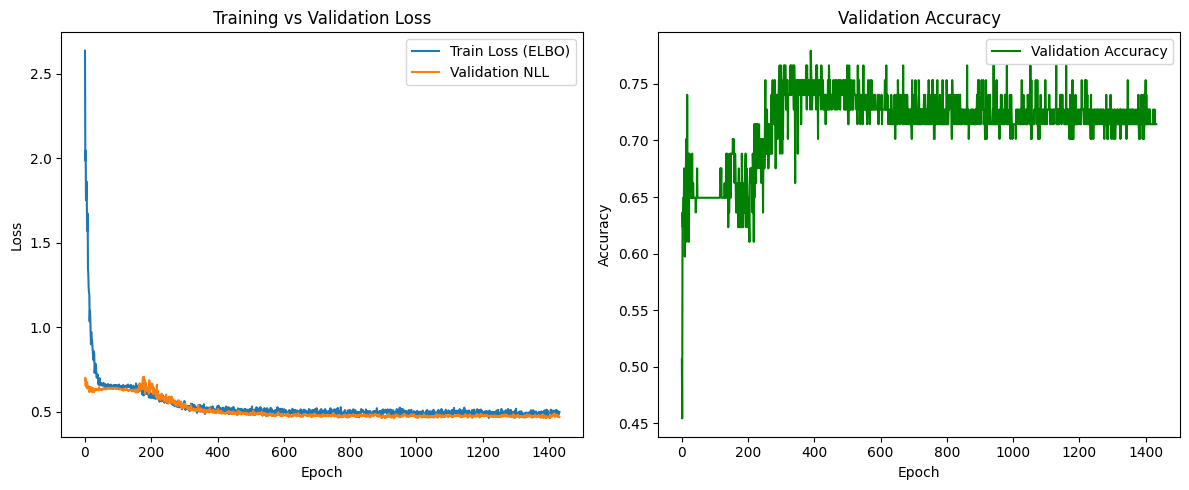

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss (ELBO)')
plt.plot(history['val_nll'], label='Validation NLL')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], label='Validation Accuracy', color='green')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# I got the main code structures from the lecture notes

In [26]:
# Check the metrics on the test set
test_acc, test_probs, test_true, uncertainties = evaluate(model, test_loader, mc_samples=500)
all_uncertainties = torch.cat(uncertainties).numpy()
average_uncertainty = np.mean(all_uncertainties, axis=0)  # Average uncertainty across samples
test_nll = criterion(test_probs, test_true).item()
test_brier = brier_score_loss(test_true, test_probs)
test_roc_auc = roc_auc_score(test_true, test_probs)
classification_rep = classification_report(test_true, (test_probs >= 0.5).float(), target_names=['No Diabetes', 'Diabetes'])


In [27]:
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test NLL: {test_nll:.4f}")
print(f"Test Brier Score: {test_brier:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}")
print(f"Test average uncertainty: {average_uncertainty:.4f}")

Test Accuracy: 0.7143
Test NLL: 0.5543
Test Brier Score: 0.1883
Test ROC AUC: 0.7681
Test average uncertainty: 0.0553


In [28]:
print(classification_rep)

              precision    recall  f1-score   support

 No Diabetes       0.76      0.82      0.79        50
    Diabetes       0.61      0.52      0.56        27

    accuracy                           0.71        77
   macro avg       0.68      0.67      0.67        77
weighted avg       0.71      0.71      0.71        77

